# Inner Core Lightning Threshold Analysis
In this notebook, we define the threshold for what constitutes a "lightning burst" in the inner core of a tropical cyclone. 

### How do we define a burst of lightning?
We define a lightning burst based off the number of lightning instances in a 30-minute time bin.
We start by assuming the distribution of lightning in the inner core is Gaussian.

*We look at each basin separately. Below are the basin codes:
* ATL - Atlantic Ocean basin
* CPAC - 
* EPAC - Eastern Pacific basin
* IO - Indian Ocean basin
* SHEM - Southern Hemisphere basin
* WPAC - Western North Pacific basin

## Code
### Import Libraries and Files
Let's start by importing necessary libraries and files. The inner core dataset is created in the `data_processing.ipynb` notebook as `innercore_timebin_joined.csv`.

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation
import matplotlib.patches as mpatches

In [2]:
# import data from csv file
innercore_data = pl.read_csv("data_pipeline/innercore_timebin_joined.csv")
innercore_data = innercore_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightning_count").log1p().alias("log_lightning_count"),
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
innercore_data = innercore_data.with_columns(
    pl.when(pl.col("TC_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("TC_Category"))
    .alias("TC_Category")
)
innercore_data = innercore_data.rename({"Intensification_Category":"Intensification_Category_5", "TC_Category":"Current_Category"})
innercore_data.head()

time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,minute_right,24_hour_knots_diff,24_hour_pressure_diff,Current_Category,Intensification_Category_5,log_lightning_count
datetime[μs],str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,i64,f64,f64,str,str,f64
2010-06-21 07:00:00,"""ATL_10_1""",1,2010,6,21,7,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.693147
2010-06-21 07:30:00,"""ATL_10_1""",0,2010,6,21,7,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0
2010-06-21 08:00:00,"""ATL_10_1""",0,2010,6,21,8,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0
2010-06-21 08:30:00,"""ATL_10_1""",0,2010,6,21,8,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0
2010-06-21 09:00:00,"""ATL_10_1""",0,2010,6,21,9,0,14.0,-67.6,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0


We map the intensification bins into 3, combining the rapidly weakening and weakening bins, and the rapidly intensifying and intensifying bins.

In [3]:
# Mapping intensification bins into 3 category instead of 5
category_mapping = {
    "Rapidly Weakening": "Weakening",
    "Weakening": "Weakening",
    "Neutral": "Neutral",
    "Intensifying": "Intensifying",
    "Rapidly Intensifying": "Intensifying"
}

# Apply mapping to create new column
innercore_data = innercore_data.with_columns(
    innercore_data["Intensification_Category_5"].replace(category_mapping).alias("Intensification_Category_3")
)

innercore_data.head()

time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,minute_right,24_hour_knots_diff,24_hour_pressure_diff,Current_Category,Intensification_Category_5,log_lightning_count,Intensification_Category_3
datetime[μs],str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,i64,f64,f64,str,str,f64,str
2010-06-21 07:00:00,"""ATL_10_1""",1,2010,6,21,7,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.693147,"""Neutral"""
2010-06-21 07:30:00,"""ATL_10_1""",0,2010,6,21,7,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0,"""Neutral"""
2010-06-21 08:00:00,"""ATL_10_1""",0,2010,6,21,8,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0,"""Neutral"""
2010-06-21 08:30:00,"""ATL_10_1""",0,2010,6,21,8,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0,"""Neutral"""
2010-06-21 09:00:00,"""ATL_10_1""",0,2010,6,21,9,0,14.0,-67.6,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0,"""Neutral"""


In [4]:
# create dataframe for filtering later
storm_names = innercore_data[["storm_code", "storm_name"]].unique()

### Functions

Below are the functions used to evaluate 6 different lightning burst thresholds at the individual TC level. We compare each TC's lightning to itself to identify a burst using the IQR, MAD, and Lognormal methods. The thresholds defined by each of these functions act as a standard for a lightning burst for that TC. If the count in the bin is more than the threshold, we mark it as a lightning burst. Note that we use log-transformed lightning counts in this analysis. We do not include data associated with current wind speeds less than 40 knots in this threshold analysis. 

We also create functions to apply the thresholds and aggregate results, as well as functions used to plot individual TCs for analysis.

In [5]:
# IQR threshold function
def detect_bursts_iqr(group):
    Q1 = group['log_lightning_count'].quantile(0.25)
    Q3 = group['log_lightning_count'].quantile(0.75)
    IQR = Q3 - Q1

    # Set burst threshold for each cyclone individually
    threshold1 = Q3 + 1 * IQR
    threshold2 = Q3 + 1.5* IQR

    # Mark bursts specific to the cyclone
    group['burst_iqr_1'] = group['log_lightning_count'] > threshold1
    group['burst_iqr_2'] = group['log_lightning_count'] > threshold2
    group['iqr_1'] = threshold1
    group['iqr_2'] = threshold2
    return group

In [6]:
# MAD threshold function
def detect_bursts_mad(group):
    median_log = group['log_lightning_count'].median()
    mad_log = median_abs_deviation(group['log_lightning_count'])

    # Set burst threshold based on MAD for each cyclone
    threshold1 = median_log + 4 * mad_log
    threshold2 = median_log + 5 * mad_log

    # Mark bursts specific to the cyclone
    group['burst_mad_1'] = group['log_lightning_count'] > threshold1
    group['burst_mad_2'] = group['log_lightning_count'] > threshold2
    group['mad_1'] = threshold1
    group['mad_2'] = threshold2
    return group

In [7]:
# Log normal threshold function
def detect_bursts_lognormal(group):
     # Calculate the mean and standard deviation of the log-transformed lightning count
    mean_log = group['log_lightning_count'].mean()
    std_log = group['log_lightning_count'].std()

    # Set burst thresholds based on log-normal distribution (mean + 2σ and mean + 3σ)
    threshold1 = mean_log + 2 * std_log
    threshold2 = mean_log + 3 * std_log

    # Mark bursts specific to the cyclone
    group['burst_lognormal_1'] = group['log_lightning_count'] > threshold1
    group['burst_lognormal_2'] = group['log_lightning_count'] > threshold2
    group['lognormal_2sigma'] = threshold1
    group['lognormal_3sigma'] = threshold2
    return group

In [8]:
# Function to apply the 3 methods, 6 thresholds for individual TCs
def apply_individual_thresholds(df):
    processed = df.groupby(["storm_code"]).apply(detect_bursts_iqr)
    processed.reset_index(drop=True, inplace=True)
    processed = processed.groupby(["storm_code"]).apply(detect_bursts_mad)
    processed.reset_index(drop=True, inplace=True)
    processed = processed.groupby(["storm_code"]).apply(detect_bursts_lognormal)
    processed.reset_index(drop=True, inplace=True)

    processed.sort_values(by=["storm_code", "time_bin"], inplace=True)
    processed.reset_index(drop=True, inplace=True)
    return processed

In [9]:
# Function used to aggregate results dataframe
def create_agg_result(processed):
    agg_result = processed.groupby(["storm_code"]).agg(
        mad1_bursts=('burst_mad_1', 'sum'),
        mad2_bursts=('burst_mad_2', 'sum'),
        mad1_threshold=('mad_1', 'max'),
        mad2_threshold=('mad_2', 'max'),
        iqr1_bursts=('burst_iqr_1', 'sum'),
        iqr2_bursts=('burst_iqr_2', 'sum'),
        iqr1_threshold=('iqr_1', 'max'),
        iqr2_threshold=('iqr_2', 'max'),
        logn1_bursts=('burst_lognormal_1', 'sum'),
        logn2_bursts=('burst_lognormal_2', 'sum'),
        logn1_threshold=('lognormal_2sigma', 'max'),
        logn2_threshold=('lognormal_3sigma', 'max'),
        total_bins=('storm_code', 'count')
    )
    agg_result.reset_index(drop=False, inplace=True)
    agg_result.head(10)

    agg_result["mad1_prop"] = round((agg_result["mad1_bursts"]/agg_result["total_bins"])*100, 2)
    agg_result["mad2_prop"] = round((agg_result["mad2_bursts"]/agg_result["total_bins"])*100, 2)
    agg_result["iqr1_prop"] = round((agg_result["iqr1_bursts"]/agg_result["total_bins"])*100, 2)
    agg_result["iqr2_prop"] = round((agg_result["iqr2_bursts"]/agg_result["total_bins"])*100, 2)
    agg_result["logn1_prop"] = round((agg_result["logn1_bursts"]/agg_result["total_bins"])*100, 2)
    agg_result["logn2_prop"] = round((agg_result["logn2_bursts"]/agg_result["total_bins"])*100, 2)
    return agg_result

In [72]:
def add_bg_colors(ax, lightning_data, color_type):
    """
    Adds background shading based on either the 'Intensification_Category_3' column or 'Current_Category' column.

    Parameters:
    - ax: The matplotlib axis to plot on.
    - lightning_data: DataFrame with 'time_bin', 'Intensification_Category_3', and 'Current_Category'
    - color_type: toggle between coloring by intensification change category or current category, can only take i3, i5, c5 as values
    """
    # Define color mapping
    i3_colors = {
        "Intensifying": "#FFEE8C",
        "Neutral": "lightgreen",
        "Weakening": "lightblue",
        "Unidentified":"white"
    }
    i5_colors = {
        "Rapidly Intensifying": "#f6aeae",
        "Intensifying": "#FFEE8C",
        "Neutral": "lightgreen",
        "Weakening": "lightblue",
        "Rapidly Weakening": "#dab1da",
        "Unidentified":"white"
    }
    c5_colors = {
        "0":'white',
        "1":'#FFEE8C',
        "2":'lightgreen',
        "3":'lightblue',
        "4":'#dab1da',
        "5":'pink'
    }

    # Define color_type toggle
    color_type_toggle = {
        "i3":["Intensification_Category_3", i3_colors],
        "i5":["Intensification_Category_5", i5_colors],
        "c5":["Current_Category", c5_colors]
    }
    # Exit if inputted color type is not valid
    if color_type not in color_type_toggle.keys():
        return(print(f"Not a valid background color type. Choose either: {', '.join(color_type_toggle.keys())}"))

    category_colors = color_type_toggle[color_type][1]
    column_name = color_type_toggle[color_type][0]
    for i in range(len(lightning_data) - 1):
        category = lightning_data[column_name].iloc[i]
        color = category_colors.get(category, "red")  # Default to red if not found - flag this as an error

        ax.axvspan(lightning_data['time_bin'].iloc[i],
                   lightning_data['time_bin'].iloc[i + 1],
                   color=color, alpha=0.3)

    # Create custom legend patches
    legend_patches = [mpatches.Patch(color=c, label=cat) for cat, c in category_colors.items()]
    return legend_patches  # Return legend handles

In [37]:
# Function to plot an individual TC with intensification in the background
def plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, bg_type):
    cyclone_name = storm_names.filter(pl.col("storm_code") == cyclone_id)["storm_name"].item()
    df_cyclone = processed[processed['storm_code'] == cyclone_id]
    lightning_data = innercore_data.filter(pl.col("storm_code") == cyclone_id).to_pandas()

    plt.figure(figsize=(10, 5))

    # Create first y-axis for lightning
    fig, ax1 = plt.subplots(figsize=(14, 8))

    ax1.plot(lightning_data['time_bin'], lightning_data['lightning_count'], label='Lightning Count', color='gray')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Lightning Count", color="gray")
    ax1.tick_params(axis='y', labelcolor="gray")

    # Create second y-axis for pressure
    ax2 = ax1.twinx()
    ax2.plot(lightning_data['time_bin'], lightning_data['pressure'], label='Pressure', color='orange')
    ax2.set_ylabel("Pressure", color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")

    # Create third y-axis for wind knot
    ax2 = ax1.twinx()
    ax2.plot(lightning_data['time_bin'], lightning_data['knots'], label='Wind', color='blue')
    ax2.set_ylabel("Wind", color="blue")
    ax2.tick_params(axis='y', labelcolor="blue")

    # Call bg colors function
    legend_patches = add_bg_colors(ax1, lightning_data, bg_type)

    # Mark bursts detected by MAD
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_1']],
                df_cyclone['lightning_count'][df_cyclone['burst_mad_1']],
                color='red', label='MAD Detected Burst -threshold1', s=50, marker='o', alpha=0.7)
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_2']],
                df_cyclone['lightning_count'][df_cyclone['burst_mad_2']],
                color='yellow', label='MAD Detected Burst - threshold2', s=50, marker='o', alpha=0.7)

    # Mark bursts detected by IQR
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_1']],
                df_cyclone['lightning_count'][df_cyclone['burst_iqr_1']],
                color='blue', label='IQR Detected Burst - threshold1', s=50, marker='x', alpha=0.7)
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_2']],
                df_cyclone['lightning_count'][df_cyclone['burst_iqr_2']],
                color='green', label='IQR Detected Burst - threshold2', s=50, marker='x', alpha=0.7)

    # Mark bursts detected by lognormal threshold
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_1']],
                df_cyclone['lightning_count'][df_cyclone['burst_lognormal_1']],
                color='purple', label='Lognormal Detected Burst - 2 sigma', s=50, marker='^', alpha=0.7)
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_2']],
                df_cyclone['lightning_count'][df_cyclone['burst_lognormal_2']],
                color='orange', label='Lognormal Detected Burst - 3 sigma', s=50, marker='^', alpha=0.7)

    plt.xlabel('Time')
    plt.title(f'Lightning Burst Detection for {cyclone_name} ({cyclone_id})')
    ax1.legend(loc='upper left')
    ax2.legend(handles=legend_patches, loc='center left')
    plt.xticks(visible=False)
    plt.grid()
    plt.show()

### Individual TC Analysis
We start by applying the 6 different thresholds to each TC individually, where we evaluate burst thresholds in comparison to a TC's own lightning activity for time bins associated with wind speeds greater than or equal to 40 knots. We start by filtering out data associated with wind speeds less than 40 knots.

In [11]:
# filter out data where wind is less than 40 knots for threshold analysis
analysis_data = innercore_data.filter(pl.col("knots") >= 40)
# convert polars dataframe to pandas for application of functions
pd_data = analysis_data.to_pandas()

We then apply the functions to the data, including timebins with no lightning activity.

In [12]:
# apply functions to data, including bins with 0 lightning
processed_w_0 = apply_individual_thresholds(pd_data)

agg_result_w_0 = create_agg_result(processed_w_0)
agg_result_w_0.head(10)

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,ATL_10_1,40,40,0.000000,0.000000,40,40,0.000000,0.000000,10,4,1.964998,2.766760,168,23.81,23.81,23.81,23.81,5.95,2.38
1,ATL_10_11,54,54,0.000000,0.000000,54,54,0.000000,0.000000,25,17,0.905833,1.299925,524,10.31,10.31,10.31,10.31,4.77,3.24
2,ATL_10_12,83,83,0.000000,0.000000,83,83,0.000000,0.000000,24,10,2.714949,3.820770,347,23.92,23.92,23.92,23.92,6.92,2.88
3,ATL_10_13,43,35,1.732868,2.079442,6,1,4.552490,5.690612,6,0,4.401910,5.986869,130,33.08,26.92,4.62,0.77,4.62,0.00
4,ATL_10_14,23,23,0.000000,0.000000,23,23,0.000000,0.000000,15,5,1.092380,1.547290,144,15.97,15.97,15.97,15.97,10.42,3.47
5,ATL_10_17,75,75,0.000000,0.000000,57,56,1.386294,1.732868,24,2,3.893827,5.435464,270,27.78,27.78,21.11,20.74,8.89,0.74
6,ATL_10_18,0,0,7.791445,9.023858,0,0,6.425564,7.595410,3,0,5.929778,7.469033,180,0.00,0.00,0.00,0.00,1.67,0.00
7,ATL_10_19,58,58,0.000000,0.000000,1,0,5.344880,6.681100,6,0,4.938227,6.723796,120,48.33,48.33,0.83,0.00,5.00,0.00
8,ATL_10_20,12,7,3.465736,4.158883,6,1,4.394449,5.493061,5,0,4.549465,6.195277,77,15.58,9.09,7.79,1.30,6.49,0.00
9,ATL_10_21,100,75,3.465736,4.158883,35,2,5.545177,6.931472,34,0,5.640493,7.671843,476,21.01,15.76,7.35,0.42,7.14,0.00


In [13]:
# get mean threshold value for each of the 6 options
agg_result_w_0_mean = agg_result_w_0.drop(columns=("storm_code")).mean()
print(agg_result_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# get median threshold value for each of the 6 options
agg_result_w_0_median = agg_result_w_0.drop(columns=("storm_code")).median()
print(agg_result_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

mad1_threshold     1.080206
mad2_threshold     1.289705
iqr1_threshold     2.292736
iqr2_threshold     2.859537
logn1_threshold    3.085677
logn2_threshold    4.239224
dtype: float64
mad1_threshold     0.000000
mad2_threshold     0.000000
iqr1_threshold     1.386294
iqr2_threshold     1.732868
logn1_threshold    2.925341
logn2_threshold    4.069471
dtype: float64


We can see that the threshold values are all very low, meaning that any lightning activity is likely to be flagged as a burst. We plot one TC below to look at a specific example. This can be expected, as we know that many of the timebins have no lightning activity, therefore skewing the threshold lower.

<Figure size 1000x500 with 0 Axes>

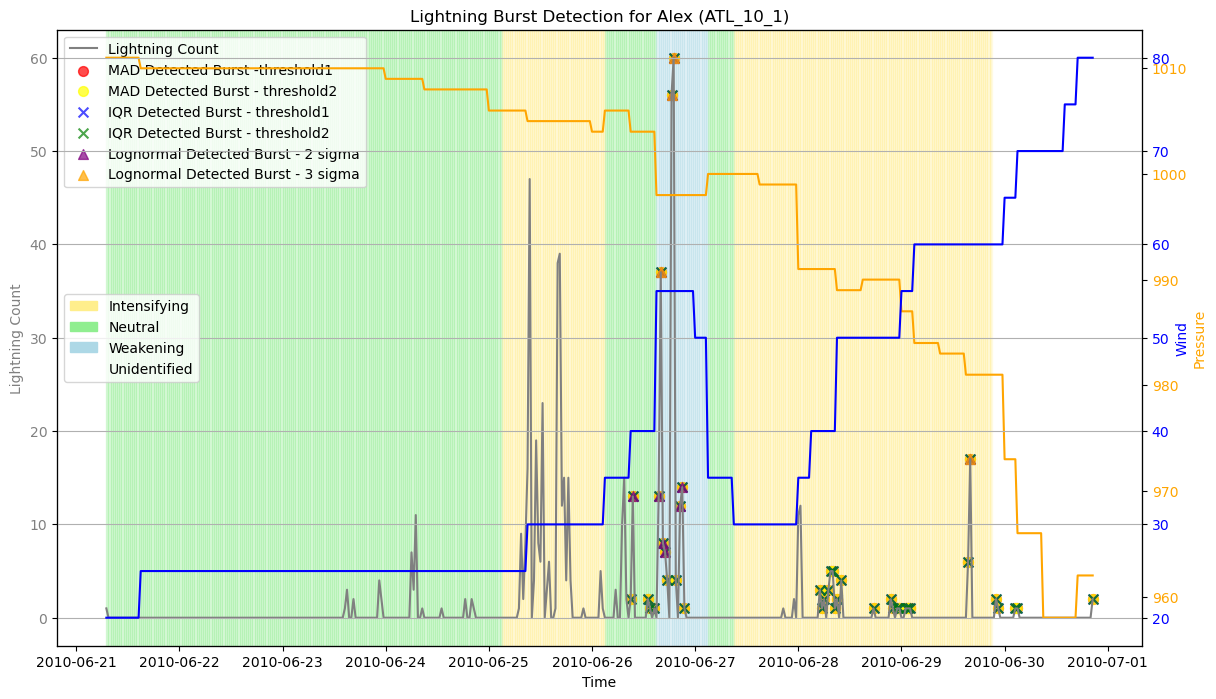

<Figure size 1000x500 with 0 Axes>

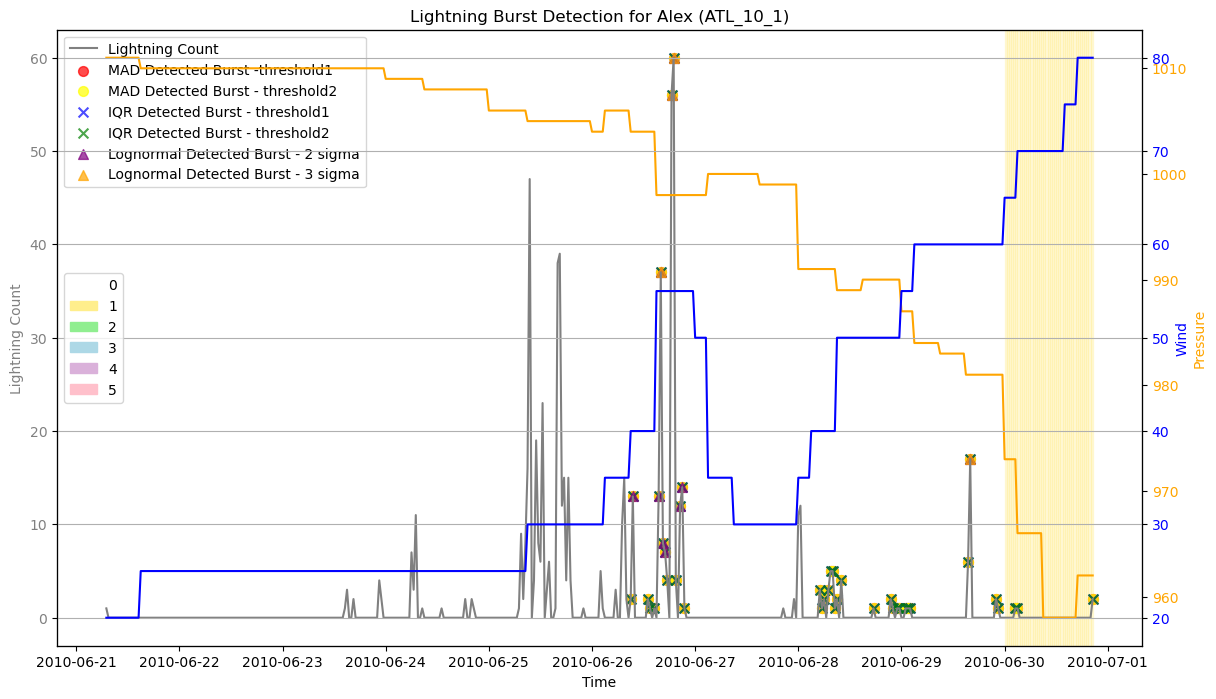

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,ATL_10_1,40,40,0.0,0.0,40,40,0.0,0.0,10,4,1.964998,2.76676,168,23.81,23.81,23.81,23.81,5.95,2.38


In [63]:
# ATL_10_1 with 0 in the analysis
cyclone_id = 'ATL_10_1'
plot_tc_intensification(cyclone_id, processed_w_0, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed_w_0, storm_names, innercore_data, "c5")
# print the summary for this storm
agg_result_w_0[agg_result_w_0["storm_code"] == cyclone_id]

Next, we try applying the thresholds to the dataset without timebins with 0 lightning count. This slightly alters our definition of a lightning burst - we now compare each set of lightning events to other nonzero lightning events. This should bring up the threshold and bring down the percent of timebins flagged as a burst.

In [15]:
# apply functions to data(exclude 0 lightning count)
pd_data_0 = pd_data[pd_data['lightning_count'] != 0]

processed = apply_individual_thresholds(pd_data_0)

agg_result = create_agg_result(processed)
agg_result.head(10)

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,ATL_10_1,4,3,2.720473,3.125938,3,2,3.265439,3.908512,3,0,3.469047,4.444476,40,10.0,7.5,7.50,5.0,7.50,0.0
1,ATL_10_11,25,25,0.693147,0.693147,0,0,2.525729,2.983874,2,0,2.310380,2.894751,54,46.3,46.3,0.00,0.0,3.70,0.0
2,ATL_10_12,0,0,6.186209,7.284821,1,0,5.295814,6.446481,3,0,4.750063,6.073002,83,0.0,0.0,1.20,0.0,3.61,0.0
3,ATL_10_13,0,0,6.275592,7.268844,4,0,5.205379,6.160151,3,0,5.278519,6.685786,65,0.0,0.0,6.15,0.0,4.62,0.0
4,ATL_10_14,0,0,2.720473,3.125938,1,0,2.079442,2.426015,1,0,2.031772,2.476167,23,0.0,0.0,4.35,0.0,4.35,0.0
5,ATL_10_17,0,0,8.435549,9.821844,0,0,6.852734,8.140767,1,0,6.020799,7.572206,75,0.0,0.0,0.00,0.0,1.33,0.0
6,ATL_10_18,0,0,7.438972,8.537584,0,0,6.448322,7.573925,3,0,5.791637,7.141587,166,0.0,0.0,0.00,0.0,1.81,0.0
7,ATL_10_19,0,0,8.612224,10.057410,0,0,7.115898,8.548299,0,0,5.959108,7.524432,58,0.0,0.0,0.00,0.0,0.00,0.0
8,ATL_10_20,0,0,6.591674,7.690286,0,0,6.278521,7.573499,1,0,5.512382,7.026859,39,0.0,0.0,0.00,0.0,2.56,0.0
9,ATL_10_21,0,0,8.462434,9.956816,0,0,8.116703,9.871226,2,0,6.777117,8.698822,256,0.0,0.0,0.00,0.0,0.78,0.0


<Figure size 1000x500 with 0 Axes>

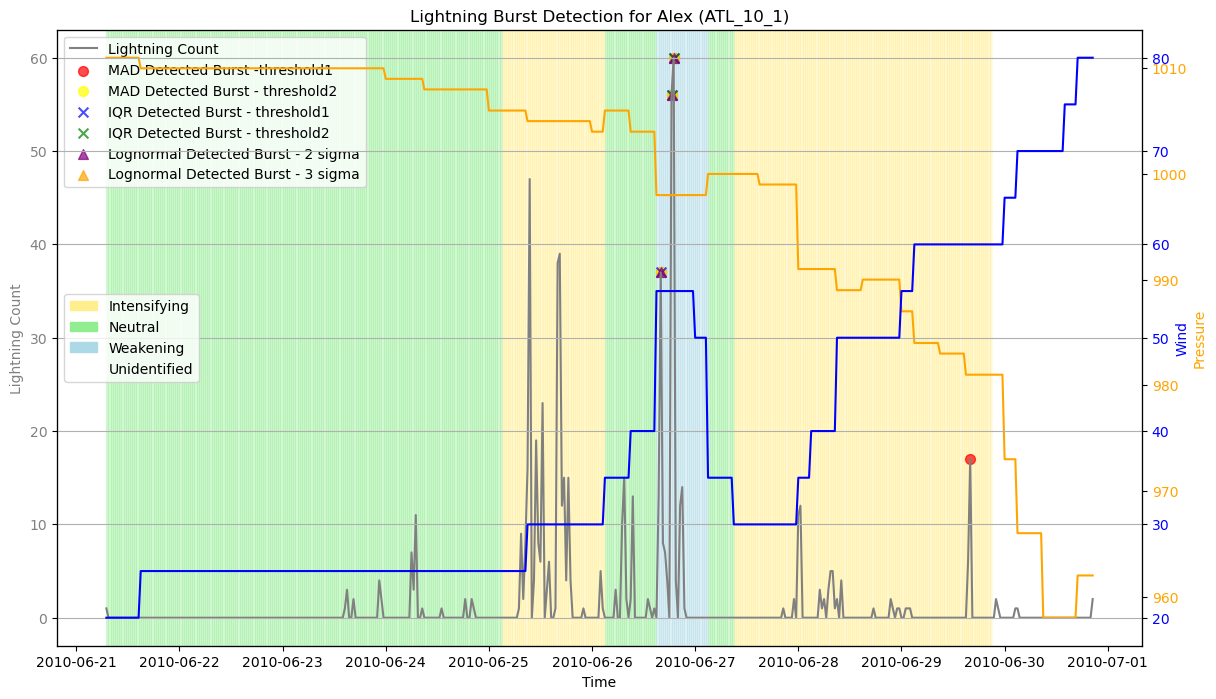

<Figure size 1000x500 with 0 Axes>

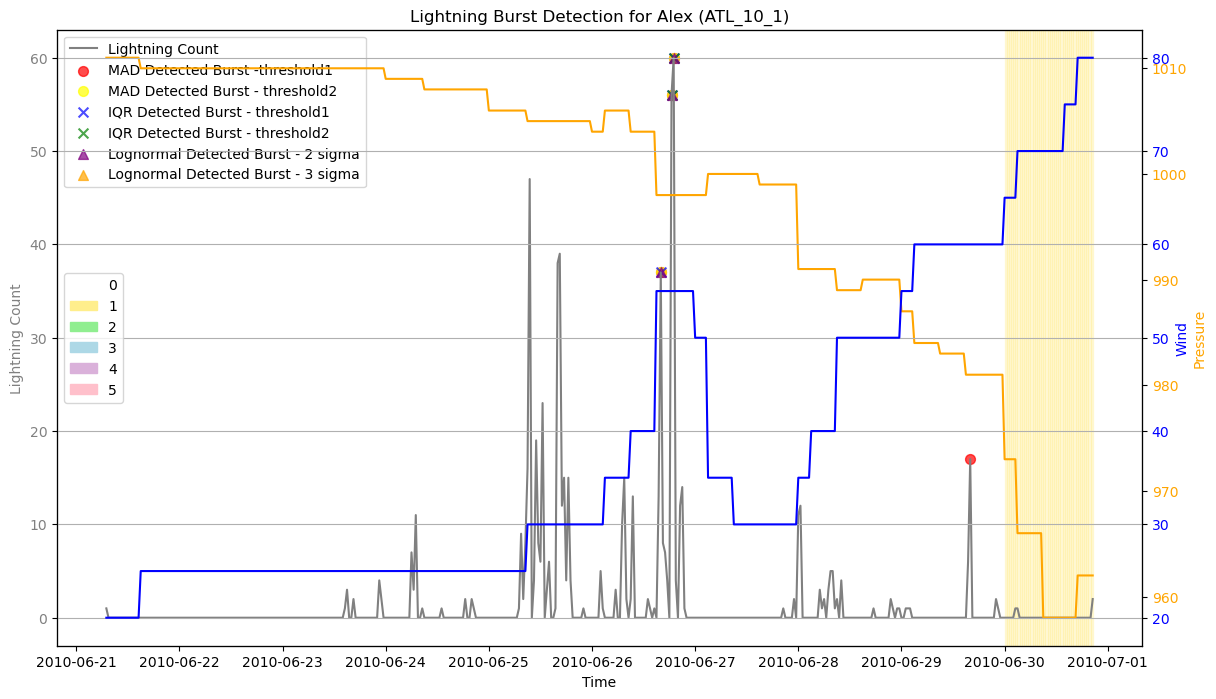

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,ATL_10_1,40,40,0.0,0.0,40,40,0.0,0.0,10,4,1.964998,2.76676,168,23.81,23.81,23.81,23.81,5.95,2.38


In [64]:
# ATL_10_1 without 0 in threshold calculation
cyclone_id = 'ATL_10_1'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# print the summary for this storm
agg_result_w_0[agg_result_w_0["storm_code"] == cyclone_id]

We see above that the analysis including timebins with 0 lightning events skews the threshold to 0, such that any lightning event is flagged as a burst. This is not realistic, and so we will not include the timebins with 0 lightning events in our threshold analysis.

Below, we look at a couple more TCs. We plot the lightning, wind, pressure, all detected lightning bursts using the 6 thresholds created above, and their intensification category/current category bins as color-coded backgrounds. Note that all data is plotted, regardless of if the point was included in the analysis (we do not consider data points associated with winds less than 40 knots in our threshold analysis).

<Figure size 1000x500 with 0 Axes>

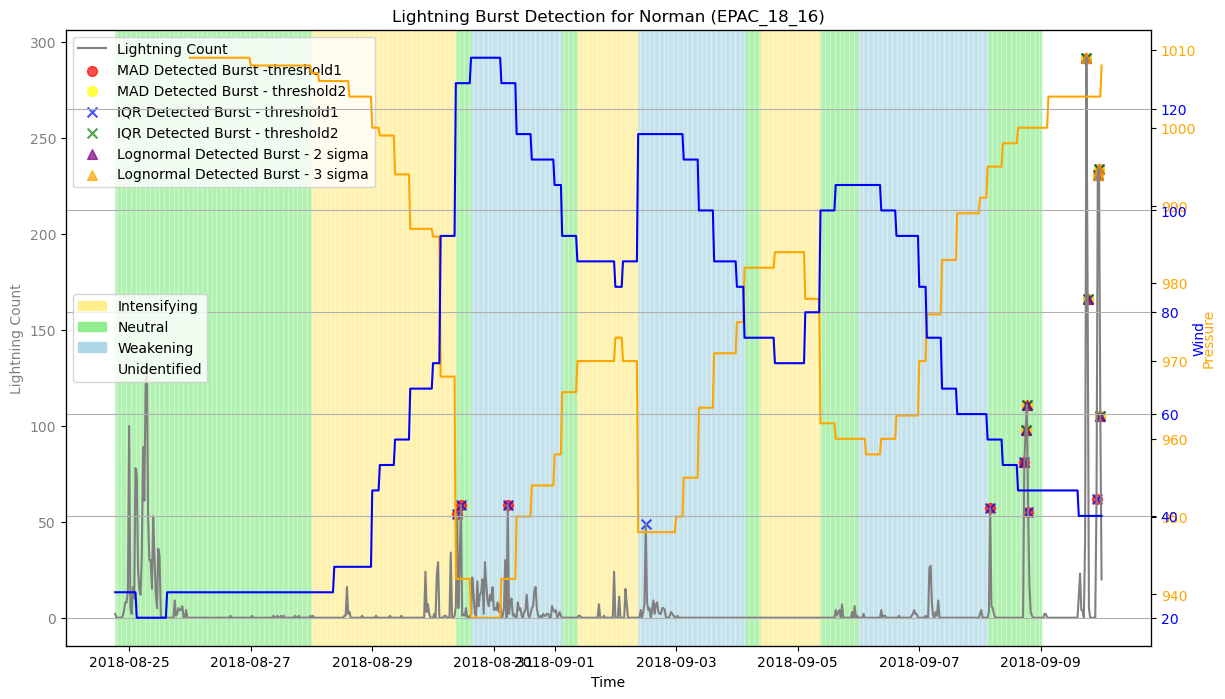

<Figure size 1000x500 with 0 Axes>

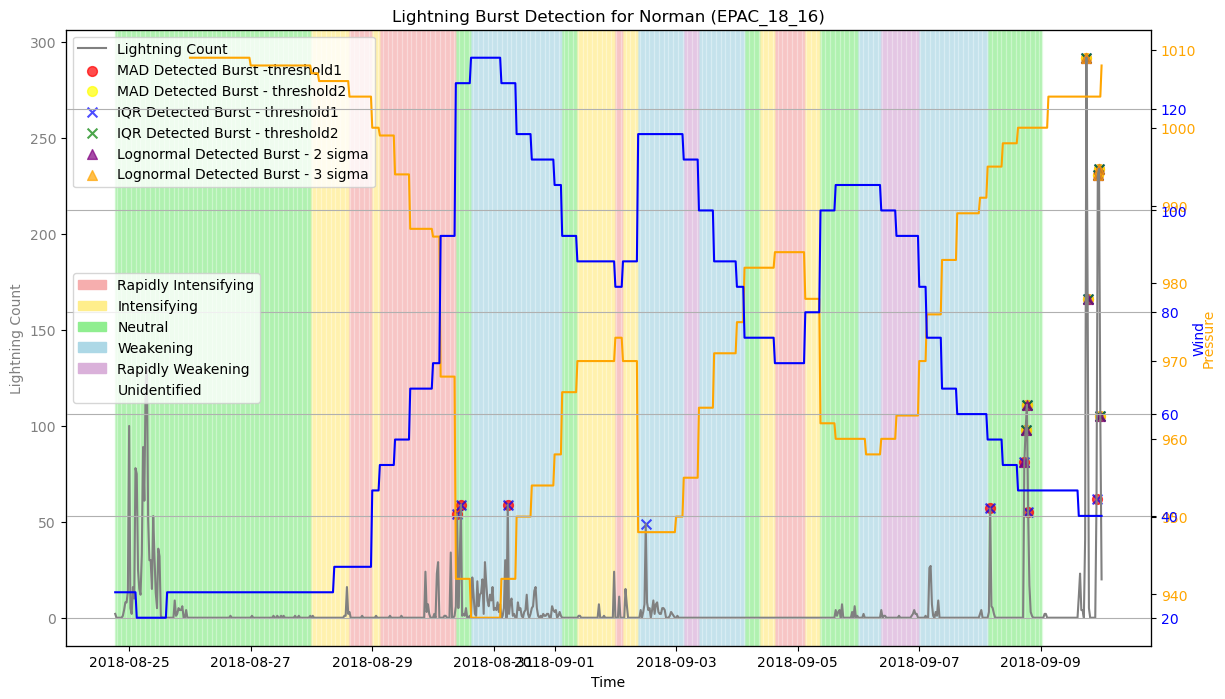

<Figure size 1000x500 with 0 Axes>

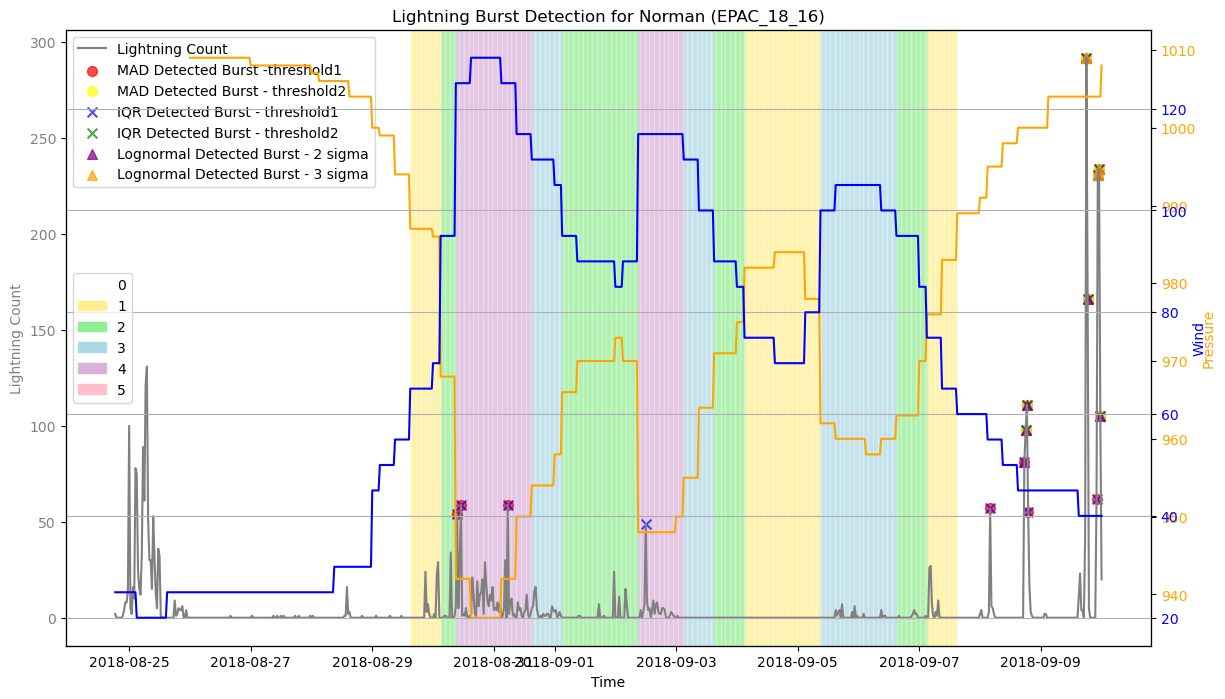

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
154,EPAC_18_16,170,170,0.0,0.0,98,81,1.386294,1.732868,36,15,2.713764,3.788067,577,29.46,29.46,16.98,14.04,6.24,2.6


In [74]:
# EPAC_18_16 - Norman
cyclone_id = 'EPAC_18_16'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# print the summary for this storm
agg_result_w_0[agg_result_w_0["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

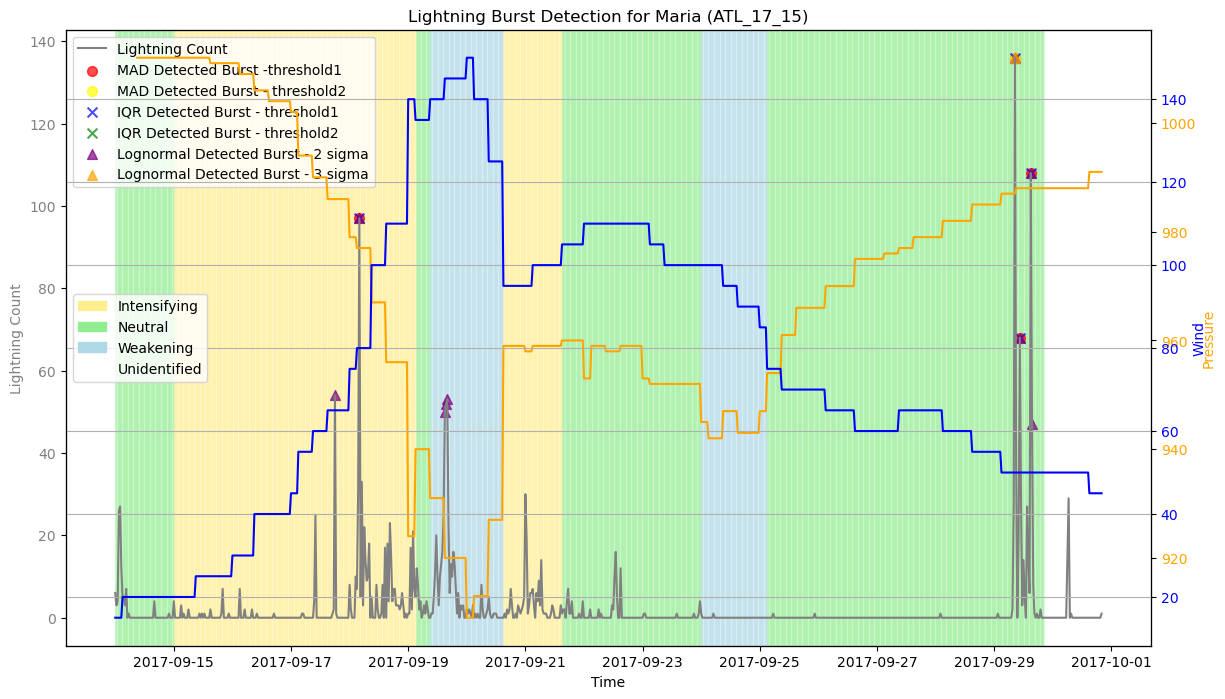

<Figure size 1000x500 with 0 Axes>

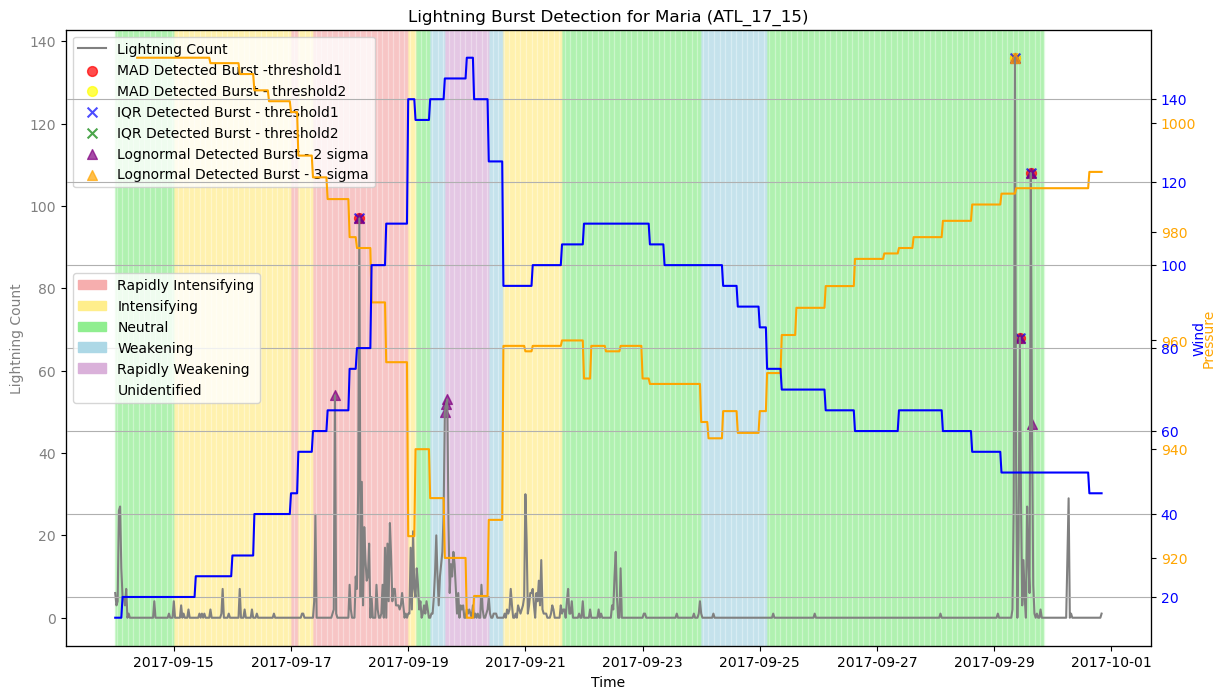

<Figure size 1000x500 with 0 Axes>

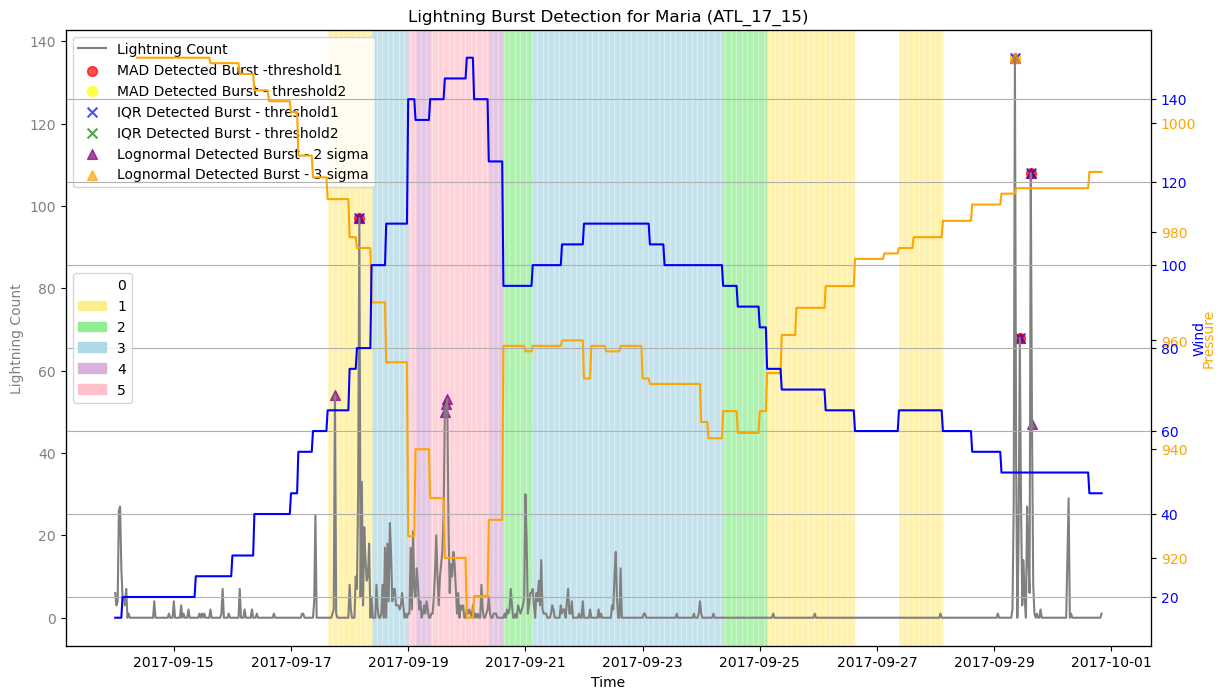

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
50,ATL_17_15,191,191,0.0,0.0,92,82,1.386294,1.732868,51,17,2.35764,3.29755,695,27.48,27.48,13.24,11.8,7.34,2.45


In [73]:
# ATL_17_15 - Maria
cyclone_id = 'ATL_17_15'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# print the summary for this storm
agg_result_w_0[agg_result_w_0["storm_code"] == cyclone_id]

In [ ]:
# export for external tool vis
innercore_data.write_csv("vis_data/tc_lightning_vis_data.csv")
agg_result.to_csv("vis_data/threshold_summary.csv")
processed.to_csv("vis_data/tc_threshold.csv")

### EPAC Basin
We now look at lightning burst thresholds at the basin level. We take the individual TC thresholds for TCs in the EPAC basin and create a basin-level standard separated by current category, where categories 0-2 are grouped together and categories 3-5 are grouped together.

In [90]:
epac_data = innercore_data.filter(pl.col("basin") == "EPAC")
epac_storm_codes = epac_data["storm_code"].unique()
epac_storm_codes.head()

storm_code
str
"""EPAC_19_1"""
"""EPAC_18_21"""
"""EPAC_11_9"""
"""EPAC_19_6"""
"""EPAC_14_7"""
"""EPAC_13_13"""
"""EPAC_19_15"""
"""EPAC_13_7"""
"""EPAC_16_20"""


In [92]:
# basin-level summary of bursts
epac_agg_result = agg_result[agg_result["storm_code"].isin(epac_storm_codes)]
epac_agg_result.head()

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
91,EPAC_10_4,0,0,6.704246,7.893830,0,0,5.172376,6.190817,2,0,4.679426,5.944917,93,0.00,0.0,0.00,0.00,2.15,0.0
92,EPAC_10_9,0,0,6.063117,7.111688,3,0,4.810531,5.763852,3,0,4.643800,5.918609,84,0.00,0.0,3.57,0.00,3.57,0.0
93,EPAC_11_1,1,0,2.720473,3.125938,7,6,2.079442,2.426015,4,0,2.502932,3.150601,49,2.04,0.0,14.29,12.24,8.16,0.0
94,EPAC_11_10,0,0,10.223271,11.946037,0,0,8.230524,9.885795,0,0,6.999298,8.822181,145,0.00,0.0,0.00,0.00,0.00,0.0
95,EPAC_11_11,0,0,10.962409,12.785568,0,0,9.045240,10.829707,0,0,7.906256,9.996606,48,0.00,0.0,0.00,0.00,0.00,0.0


In [96]:
# look at summary for 0-2 and 3-5 categories
weak_cat = ["0", "1", "2"]
strong_cat = ["3", "4", "5"]
# use the processed df
epac_processed = processed[processed["storm_code"].isin(epac_storm_codes)]
epac_processed.head()

,time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,...,iqr_1,iqr_2,burst_mad_1,burst_mad_2,mad_1,mad_2,burst_lognormal_1,burst_lognormal_2,lognormal_2sigma,lognormal_3sigma
10047,2010-06-19 18:30:00,EPAC_10_4,5,2010,6,19,18,30,12.4,-97.6,...,5.172376,6.190817,False,False,6.704246,7.89383,False,False,4.679426,5.944917
10048,2010-06-19 20:30:00,EPAC_10_4,1,2010,6,19,20,30,12.4,-97.6,...,5.172376,6.190817,False,False,6.704246,7.89383,False,False,4.679426,5.944917
10049,2010-06-20 11:30:00,EPAC_10_4,1,2010,6,20,11,30,11.8,-99.5,...,5.172376,6.190817,False,False,6.704246,7.89383,False,False,4.679426,5.944917
10050,2010-06-20 12:00:00,EPAC_10_4,7,2010,6,20,12,0,11.8,-99.5,...,5.172376,6.190817,False,False,6.704246,7.89383,False,False,4.679426,5.944917
10051,2010-06-20 12:30:00,EPAC_10_4,26,2010,6,20,12,30,11.8,-99.5,...,5.172376,6.190817,False,False,6.704246,7.89383,False,False,4.679426,5.944917


In [98]:
# separate the 2 category groupings
epac_weak_cat_lightning = epac_processed[epac_processed["Current_Category"].isin(weak_cat)]
print(f"{len(epac_weak_cat_lightning)} data points associated with category {min(weak_cat)}-{max(weak_cat)} wind speeds in EPAC basin.")
epac_strong_cat_lightning = epac_processed[epac_processed["Current_Category"].isin(strong_cat)]
print(f"{len(epac_strong_cat_lightning)} data points associated with category {min(strong_cat)}-{max(strong_cat)} wind speeds in EPAC basin.")

1561 data points associated with category 0-2 wind speeds in EPAC basin.
1398 data points associated with category 3-5 wind speeds in EPAC basin.


---------------------

In [21]:
# mean number of bursts by threshold, mean threshold, mean proportion
epac_agg_summary = epac_agg_result.drop(columns=("storm_code")).groupby("Intensification_Category_3").mean()
epac_agg_summary

,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
Intensification_Category_3,,,,,,,,,,,,,,,,,,,
Intensifying,1.275000,0.887500,4.987892,5.775776,1.062500,0.450000,4.501650,5.358486,1.175000,0.0375,4.325284,5.470994,38.425000,6.204875,4.782875,4.268250,1.856125,3.139125,0.093625
Neutral,1.225000,0.875000,5.255162,6.074772,0.962500,0.300000,4.565247,5.414100,1.062500,0.0250,4.467871,5.631208,44.775000,4.910375,3.510375,3.430875,1.844625,2.200750,0.070625
Weakening,0.425532,0.106383,4.925303,5.624532,0.978723,0.297872,4.143676,4.821685,0.914894,0.0000,4.305202,5.364394,29.255319,1.942979,1.014681,3.243191,1.405319,2.025957,0.000000


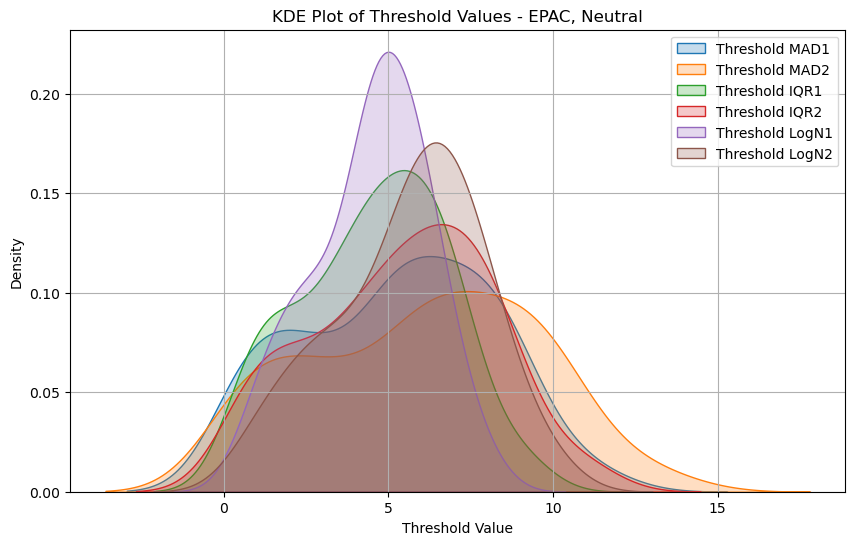

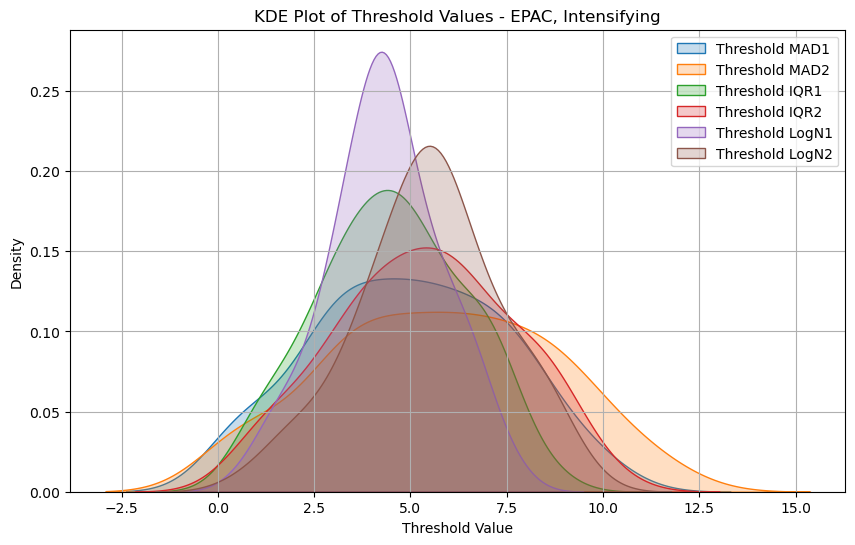

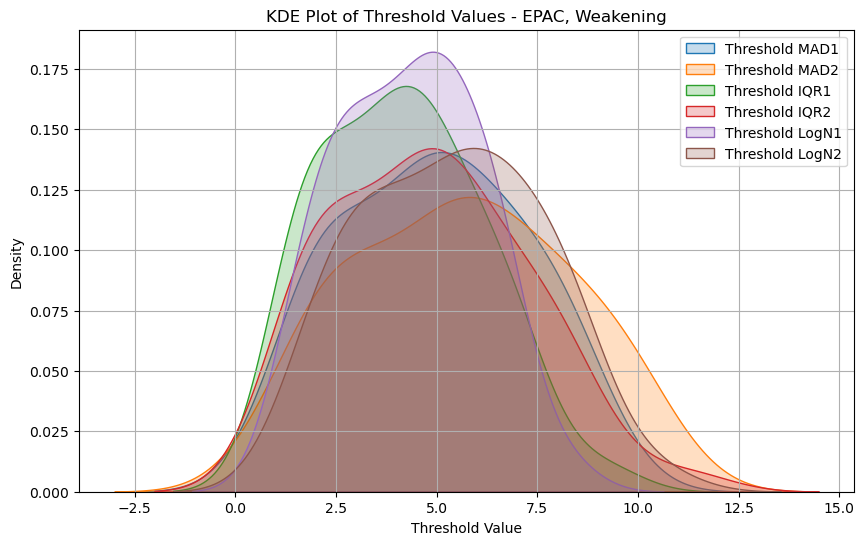

In [22]:
# Threshold value distribution
# Neutral bin
epac_agg_result_neutral = epac_agg_result[epac_agg_result["Intensification_Category_3"]=="Neutral"]
plt.figure(figsize=(10, 6))

sns.kdeplot(epac_agg_result_neutral['mad1_threshold'], label='Threshold MAD1', fill=True)
sns.kdeplot(epac_agg_result_neutral['mad2_threshold'], label='Threshold MAD2', fill=True)
sns.kdeplot(epac_agg_result_neutral['iqr1_threshold'], label='Threshold IQR1', fill=True)
sns.kdeplot(epac_agg_result_neutral['iqr2_threshold'], label='Threshold IQR2', fill=True)
sns.kdeplot(epac_agg_result_neutral['logn1_threshold'], label='Threshold LogN1', fill=True)
sns.kdeplot(epac_agg_result_neutral['logn2_threshold'], label='Threshold LogN2', fill=True)

plt.xlabel('Threshold Value')
plt.ylabel('Density')
plt.title('KDE Plot of Threshold Values - EPAC, Neutral')
plt.legend()
plt.grid()
plt.show()

# Intensifying bin
epac_agg_result_intensifying = epac_agg_result[epac_agg_result["Intensification_Category_3"]=="Intensifying"]
plt.figure(figsize=(10, 6))

sns.kdeplot(epac_agg_result_intensifying['mad1_threshold'], label='Threshold MAD1', fill=True)
sns.kdeplot(epac_agg_result_intensifying['mad2_threshold'], label='Threshold MAD2', fill=True)
sns.kdeplot(epac_agg_result_intensifying['iqr1_threshold'], label='Threshold IQR1', fill=True)
sns.kdeplot(epac_agg_result_intensifying['iqr2_threshold'], label='Threshold IQR2', fill=True)
sns.kdeplot(epac_agg_result_intensifying['logn1_threshold'], label='Threshold LogN1', fill=True)
sns.kdeplot(epac_agg_result_intensifying['logn2_threshold'], label='Threshold LogN2', fill=True)

plt.xlabel('Threshold Value')
plt.ylabel('Density')
plt.title('KDE Plot of Threshold Values - EPAC, Intensifying')
plt.legend()
plt.grid()
plt.show()

# Weakening bin
epac_agg_result_weakening = epac_agg_result[epac_agg_result["Intensification_Category_3"]=="Weakening"]
plt.figure(figsize=(10, 6))

sns.kdeplot(epac_agg_result_weakening['mad1_threshold'], label='Threshold MAD1', fill=True)
sns.kdeplot(epac_agg_result_weakening['mad2_threshold'], label='Threshold MAD2', fill=True)
sns.kdeplot(epac_agg_result_weakening['iqr1_threshold'], label='Threshold IQR1', fill=True)
sns.kdeplot(epac_agg_result_weakening['iqr2_threshold'], label='Threshold IQR2', fill=True)
sns.kdeplot(epac_agg_result_weakening['logn1_threshold'], label='Threshold LogN1', fill=True)
sns.kdeplot(epac_agg_result_weakening['logn2_threshold'], label='Threshold LogN2', fill=True)

plt.xlabel('Threshold Value')
plt.ylabel('Density')
plt.title('KDE Plot of Threshold Values - EPAC, Weakening')
plt.legend()
plt.grid()
plt.show()

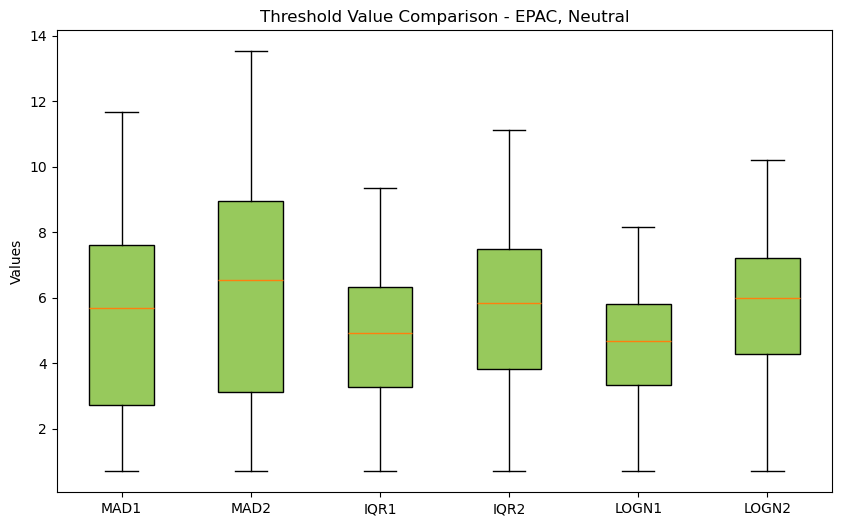

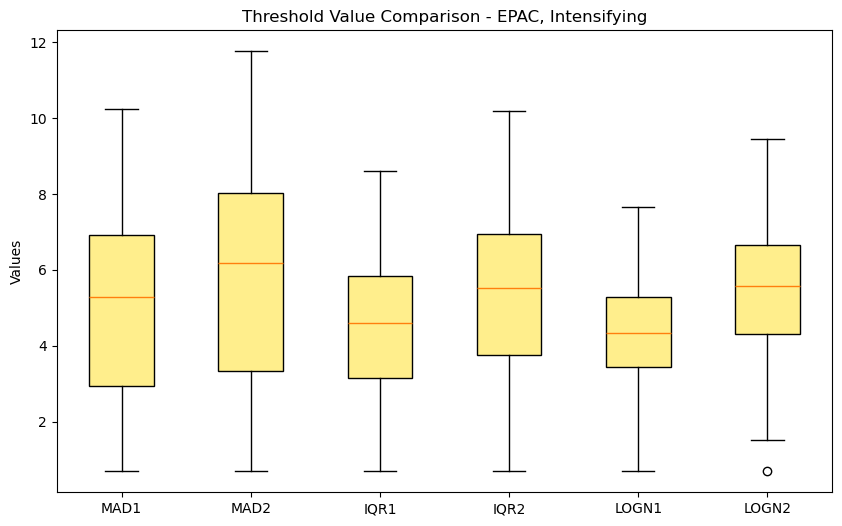

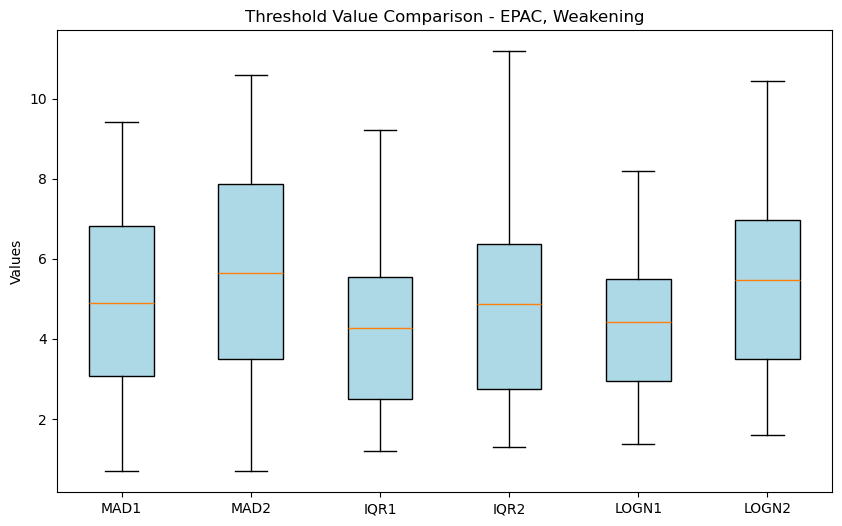

In [34]:
# Threshold value distribution - boxplot
# neutral
# dropping nulls for special case where null logn threshold bc only 1 bin in that category, cannot calculate
epac_agg_result_neutral = epac_agg_result_neutral.dropna(subset=['logn1_threshold', 'logn2_threshold'])
plt.figure(figsize=(10, 6))
plt.boxplot([epac_agg_result_neutral['mad1_threshold'], epac_agg_result_neutral['mad2_threshold'], epac_agg_result_neutral['iqr1_threshold'],
             epac_agg_result_neutral['iqr2_threshold'], epac_agg_result_neutral['logn1_threshold'], epac_agg_result_neutral['logn2_threshold']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='#97c95c'))

plt.title('Threshold Value Comparison - EPAC, Neutral')
plt.ylabel('Values')

plt.show()

# intensifying
plt.figure(figsize=(10, 6))
plt.boxplot([epac_agg_result_intensifying['mad1_threshold'], epac_agg_result_intensifying['mad2_threshold'], epac_agg_result_intensifying['iqr1_threshold'],
             epac_agg_result_intensifying['iqr2_threshold'], epac_agg_result_intensifying['logn1_threshold'], epac_agg_result_intensifying['logn2_threshold']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='#FFEE8C'))

plt.title('Threshold Value Comparison - EPAC, Intensifying')
plt.ylabel('Values')

plt.show()

# weakening
epac_agg_result_weakening = epac_agg_result_weakening.dropna(subset=['logn1_threshold', 'logn2_threshold'])
plt.figure(figsize=(10, 6))
plt.boxplot([epac_agg_result_weakening['mad1_threshold'], epac_agg_result_weakening['mad2_threshold'], epac_agg_result_weakening['iqr1_threshold'],
             epac_agg_result_weakening['iqr2_threshold'], epac_agg_result_weakening['logn1_threshold'], epac_agg_result_weakening['logn2_threshold']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='lightblue'))

plt.title('Threshold Value Comparison - EPAC, Weakening')
plt.ylabel('Values')

plt.show()

In [ ]:
# look at "effective" thresholds? how do i filter this data...

In [31]:
print(epac_agg_result_neutral[['logn1_threshold', 'logn2_threshold']].isna().sum())
# there are null values?
epac_agg_result_neutral[epac_agg_result_neutral['logn1_threshold'].isna()]

logn1_threshold    3
logn2_threshold    3
dtype: int64


,storm_code,Intensification_Category_3,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
340,EPAC_15_15,Neutral,0,0,0.693147,0.693147,0,0,0.693147,0.693147,...,0,NaN,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0
359,EPAC_15_5,Neutral,0,0,1.386294,1.386294,0,0,1.386294,1.386294,...,0,NaN,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0
372,EPAC_16_16,Neutral,0,0,0.693147,0.693147,0,0,0.693147,0.693147,...,0,NaN,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
processed[processed['storm_code'] == 'EPAC_15_15']['Intensification_Category_3']
# getting a null for the neutral logn threshold bc there's only one bin in that category

18059         Neutral
18060    Intensifying
18061    Intensifying
18062    Intensifying
18063    Intensifying
18064    Intensifying
18065    Intensifying
18066    Intensifying
18067    Intensifying
18068    Intensifying
18069    Intensifying
18070    Intensifying
Name: Intensification_Category_3, dtype: object

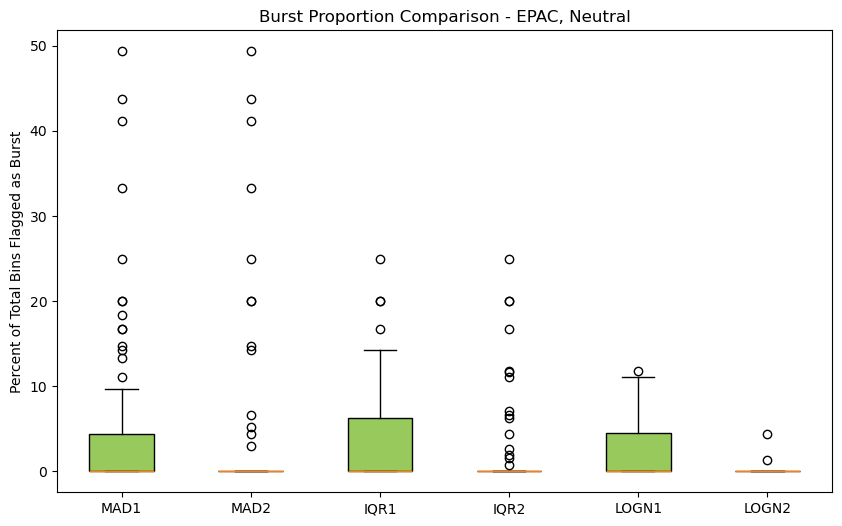

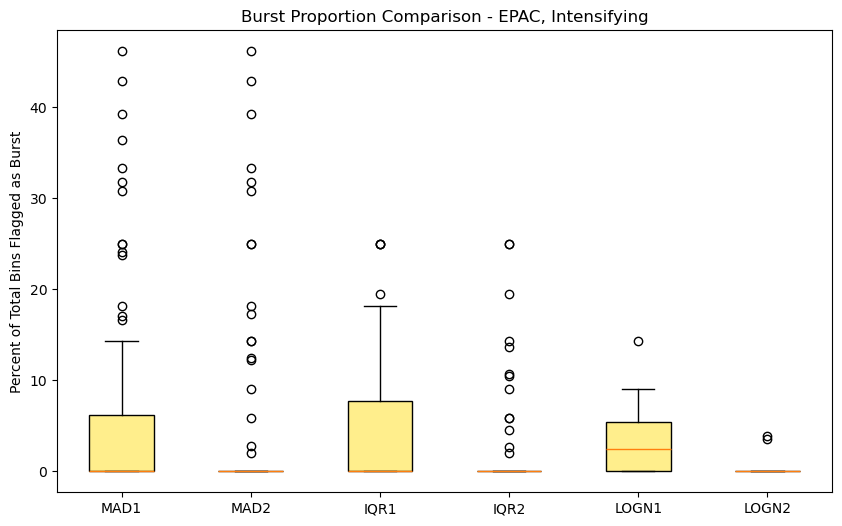

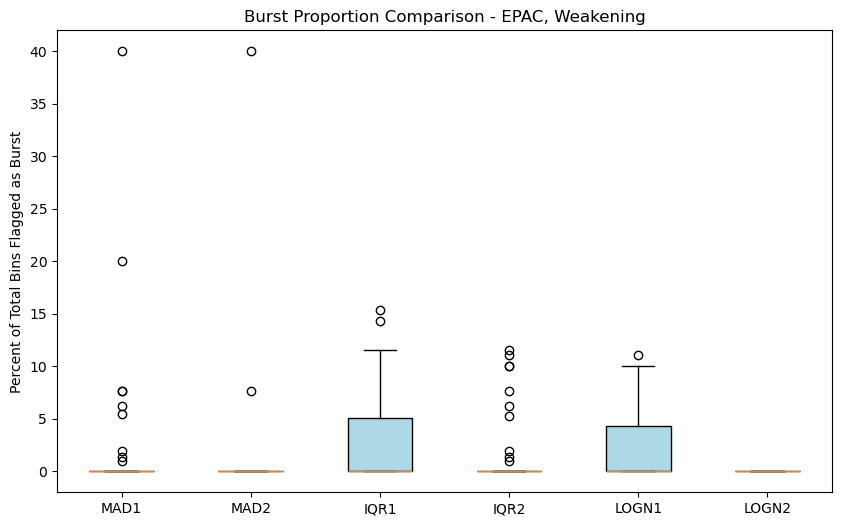

In [36]:
# burst proportion comparison - neutral
plt.figure(figsize=(10, 6))
plt.boxplot([epac_agg_result_neutral['mad1_prop'], epac_agg_result_neutral['mad2_prop'], epac_agg_result_neutral['iqr1_prop'],
             epac_agg_result_neutral['iqr2_prop'], epac_agg_result_neutral['logn1_prop'], epac_agg_result_neutral['logn2_prop']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='#97c95c'))

# Customizing the Plot
plt.title('Burst Proportion Comparison - EPAC, Neutral')
plt.ylabel('Percent of Total Bins Flagged as Burst')

plt.show()

# burst proportion comparison - intensifying
plt.figure(figsize=(10, 6))
plt.boxplot([epac_agg_result_intensifying['mad1_prop'], epac_agg_result_intensifying['mad2_prop'], epac_agg_result_intensifying['iqr1_prop'],
             epac_agg_result_intensifying['iqr2_prop'], epac_agg_result_intensifying['logn1_prop'], epac_agg_result_intensifying['logn2_prop']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='#FFEE8C'))

# Customizing the Plot
plt.title('Burst Proportion Comparison - EPAC, Intensifying')
plt.ylabel('Percent of Total Bins Flagged as Burst')

plt.show()

# burst proportion comparison - weakening
plt.figure(figsize=(10, 6))
plt.boxplot([epac_agg_result_weakening['mad1_prop'], epac_agg_result_weakening['mad2_prop'], epac_agg_result_weakening['iqr1_prop'],
             epac_agg_result_weakening['iqr2_prop'], epac_agg_result_weakening['logn1_prop'], epac_agg_result_weakening['logn2_prop']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Customizing the Plot
plt.title('Burst Proportion Comparison - EPAC, Weakening')
plt.ylabel('Percent of Total Bins Flagged as Burst')

plt.show()

In [38]:
# try using the median threshold value as the basin threshold?
epac_basin_median = {}
# Neutral bin
epac_neutral_median = {}
epac_neutral_median['mad1'] = epac_agg_result_neutral['mad1_threshold'].median()
epac_neutral_median['mad2'] = epac_agg_result_neutral['mad2_threshold'].median()
epac_neutral_median['iqr1'] = epac_agg_result_neutral['iqr1_threshold'].median()
epac_neutral_median['iqr2'] = epac_agg_result_neutral['iqr2_threshold'].median()
epac_neutral_median['logn1'] = epac_agg_result_neutral['logn1_threshold'].median()
epac_neutral_median['logn2'] = epac_agg_result_neutral['logn2_threshold'].median()
epac_basin_median['Neutral'] = epac_neutral_median
# Intensifying bin
epac_intensifying_median = {}
epac_intensifying_median['mad1'] = epac_agg_result_intensifying['mad1_threshold'].median()
epac_intensifying_median['mad2'] = epac_agg_result_intensifying['mad2_threshold'].median()
epac_intensifying_median['iqr1'] = epac_agg_result_intensifying['iqr1_threshold'].median()
epac_intensifying_median['iqr2'] = epac_agg_result_intensifying['iqr2_threshold'].median()
epac_intensifying_median['logn1'] = epac_agg_result_intensifying['logn1_threshold'].median()
epac_intensifying_median['logn2'] = epac_agg_result_intensifying['logn2_threshold'].median()
epac_basin_median['Intensifying'] = epac_intensifying_median
# Weakening bin
epac_weakening_median = {}
epac_weakening_median['mad1'] = epac_agg_result_weakening['mad1_threshold'].median()
epac_weakening_median['mad2'] = epac_agg_result_weakening['mad2_threshold'].median()
epac_weakening_median['iqr1'] = epac_agg_result_weakening['iqr1_threshold'].median()
epac_weakening_median['iqr2'] = epac_agg_result_weakening['iqr2_threshold'].median()
epac_weakening_median['logn1'] = epac_agg_result_weakening['logn1_threshold'].median()
epac_weakening_median['logn2'] = epac_agg_result_weakening['logn2_threshold'].median()
epac_basin_median['Weakening'] = epac_weakening_median

epac_basin_median

{'Neutral': {'mad1': 5.668930072165434,
  'mad2': 6.530877627725885,
  'iqr1': 4.922580145698918,
  'iqr2': 5.851414459048552,
  'logn1': 4.68137341673402,
  'logn2': 5.976382121233643},
 'Intensifying': {'mad1': 5.27460083993072,
  'mad2': 6.186645511398103,
  'iqr1': 4.601175947357306,
  'iqr2': 5.522525564070916,
  'logn1': 4.341602048261279,
  'logn2': 5.57038531915064},
 'Weakening': {'mad1': 4.89798965198572,
  'mad2': 5.645643945207524,
  'iqr1': 4.269719673634908,
  'iqr2': 4.876430921633277,
  'logn1': 4.415519279193295,
  'logn2': 5.477840284938994}}

In [39]:
# create function to apply basin threshold to lightning bins
def detect_bursts_basin(group, thresholds):
    # Identify the intensification category for the current group
    category = group['Intensification_Category_3'].iloc[0]
    # Get thresholds for this category, default to an empty dict if category is not found
    category_thresholds = thresholds.get(category, {})

    # Use thresholds passed in
    for key, value in category_thresholds.items():
        threshold = value
        group[f'burst_{key}'] = group['log_lightning_count'] > threshold
        group[f'threshold_{key}'] = threshold

    return group

In [40]:
# apply the new basin threshold to the lightning bins
epac_data_pd = epac_data.to_pandas()
# drop bins with 0 lightning count
epac_data_clean = epac_data_pd[epac_data_pd['lightning_count'] != 0]
epac_data_clean = epac_data_clean[epac_data_clean['Intensification_Category_3'] != "Unidentified"]

epac_processed = epac_data_clean.groupby(["storm_code", "Intensification_Category_3"]).apply(detect_bursts_basin, thresholds = epac_basin_median)
epac_processed.reset_index(drop=True, inplace=True)

epac_processed.sort_values(by=["storm_code", "time_bin"], inplace=True)
epac_processed.reset_index(drop=True, inplace=True)

epac_processed.head()

epac_basin_agg_result = epac_processed.groupby(["storm_code", "Intensification_Category_3"]).agg(
    mad1_bursts=('burst_mad1', 'sum'),
    mad2_bursts=('burst_mad2', 'sum'),
    mad1_threshold=('threshold_mad1', 'max'),
    mad2_threshold=('threshold_mad2', 'max'),
    iqr1_bursts=('burst_iqr1', 'sum'),
    iqr2_bursts=('burst_iqr2', 'sum'),
    iqr1_threshold=('threshold_iqr1', 'max'),
    iqr2_threshold=('threshold_iqr2', 'max'),
    logn1_bursts=('burst_logn1', 'sum'),
    logn2_bursts=('burst_logn2', 'sum'),
    logn1_threshold=('threshold_logn1', 'max'),
    logn2_threshold=('threshold_logn2', 'max'),
    total_bins=('storm_code', 'count')
)
epac_basin_agg_result.reset_index(drop=False, inplace=True)
epac_basin_agg_result.head(10)

,storm_code,Intensification_Category_3,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins
0,EPAC_10_4,Intensifying,0,0,5.274601,6.186646,1,0,4.601176,5.522526,3,0,4.341602,5.570385,51
1,EPAC_10_4,Neutral,0,0,5.668930,6.530878,0,0,4.922580,5.851414,0,0,4.681373,5.976382,28
2,EPAC_10_4,Weakening,0,0,4.897990,5.645644,1,0,4.269720,4.876431,1,0,4.415519,5.477840,4
3,EPAC_10_9,Intensifying,0,0,5.274601,6.186646,3,0,4.601176,5.522526,5,0,4.341602,5.570385,63
4,EPAC_10_9,Neutral,0,0,5.668930,6.530878,0,0,4.922580,5.851414,0,0,4.681373,5.976382,2
5,EPAC_11_1,Intensifying,0,0,5.274601,6.186646,0,0,4.601176,5.522526,0,0,4.341602,5.570385,28
6,EPAC_11_1,Neutral,0,0,5.668930,6.530878,0,0,4.922580,5.851414,0,0,4.681373,5.976382,23
7,EPAC_11_1,Weakening,0,0,4.897990,5.645644,0,0,4.269720,4.876431,0,0,4.415519,5.477840,14
8,EPAC_11_10,Intensifying,40,15,5.274601,6.186646,54,30,4.601176,5.522526,59,30,4.341602,5.570385,121
9,EPAC_11_10,Neutral,0,0,5.668930,6.530878,0,0,4.922580,5.851414,0,0,4.681373,5.976382,6


In [41]:
epac_basin_agg_result["mad1_prop"] = round((epac_basin_agg_result["mad1_bursts"]/epac_basin_agg_result["total_bins"])*100, 2)
epac_basin_agg_result["mad2_prop"] = round((epac_basin_agg_result["mad2_bursts"]/epac_basin_agg_result["total_bins"])*100, 2)
epac_basin_agg_result["iqr1_prop"] = round((epac_basin_agg_result["iqr1_bursts"]/epac_basin_agg_result["total_bins"])*100, 2)
epac_basin_agg_result["iqr2_prop"] = round((epac_basin_agg_result["iqr2_bursts"]/epac_basin_agg_result["total_bins"])*100, 2)
epac_basin_agg_result["logn1_prop"] = round((epac_basin_agg_result["logn1_bursts"]/epac_basin_agg_result["total_bins"])*100, 2)
epac_basin_agg_result["logn2_prop"] = round((epac_basin_agg_result["logn2_bursts"]/epac_basin_agg_result["total_bins"])*100, 2)
epac_basin_agg_result.head()

,storm_code,Intensification_Category_3,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
0,EPAC_10_4,Intensifying,0,0,5.274601,6.186646,1,0,4.601176,5.522526,...,0,4.341602,5.570385,51,0.0,0.0,1.96,0.0,5.88,0.0
1,EPAC_10_4,Neutral,0,0,5.668930,6.530878,0,0,4.922580,5.851414,...,0,4.681373,5.976382,28,0.0,0.0,0.00,0.0,0.00,0.0
2,EPAC_10_4,Weakening,0,0,4.897990,5.645644,1,0,4.269720,4.876431,...,0,4.415519,5.477840,4,0.0,0.0,25.00,0.0,25.00,0.0
3,EPAC_10_9,Intensifying,0,0,5.274601,6.186646,3,0,4.601176,5.522526,...,0,4.341602,5.570385,63,0.0,0.0,4.76,0.0,7.94,0.0
4,EPAC_10_9,Neutral,0,0,5.668930,6.530878,0,0,4.922580,5.851414,...,0,4.681373,5.976382,2,0.0,0.0,0.00,0.0,0.00,0.0


In [42]:
# median number of bursts by threshold, median threshold, median proportion
epac_basin_agg_summary_median = epac_basin_agg_result.drop(columns=("storm_code")).groupby("Intensification_Category_3").median()
epac_basin_agg_summary_median

,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
Intensification_Category_3,,,,,,,,,,,,,,,,,,,
Intensifying,0.0,0.0,5.274601,6.186646,0.0,0.0,4.601176,5.522526,1.0,0.0,4.341602,5.570385,33.5,0.0,0.0,0.0,0.0,2.565,0.0
Neutral,0.0,0.0,5.668930,6.530878,0.0,0.0,4.922580,5.851414,1.0,0.0,4.681373,5.976382,31.5,0.0,0.0,0.0,0.0,2.990,0.0
Weakening,0.0,0.0,4.897990,5.645644,0.0,0.0,4.269720,4.876431,0.0,0.0,4.415519,5.477840,16.0,0.0,0.0,0.0,0.0,0.000,0.0


In [43]:
# mean number of bursts by threshold, mean threshold, mean proportion
epac_basin_agg_summary = epac_basin_agg_result.drop(columns=("storm_code")).groupby("Intensification_Category_3").mean()
epac_basin_agg_summary

,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
Intensification_Category_3,,,,,,,,,,,,,,,,,,,
Intensifying,1.687500,0.475000,5.274601,6.186646,3.675000,1.250000,4.601176,5.522526,4.812500,1.16250,4.341602,5.570385,38.425000,2.731625,0.694500,6.269500,2.035625,8.191500,1.791125
Neutral,1.750000,0.400000,5.668930,6.530878,4.262500,1.262500,4.922580,5.851414,5.287500,1.06250,4.681373,5.976382,44.775000,2.019625,0.418625,5.996250,1.465125,7.519000,1.209750
Weakening,2.170213,0.808511,4.897990,5.645644,3.829787,2.191489,4.269720,4.876431,3.276596,1.06383,4.415519,5.477840,29.255319,5.345106,1.740851,10.107234,5.360213,8.620851,2.146170


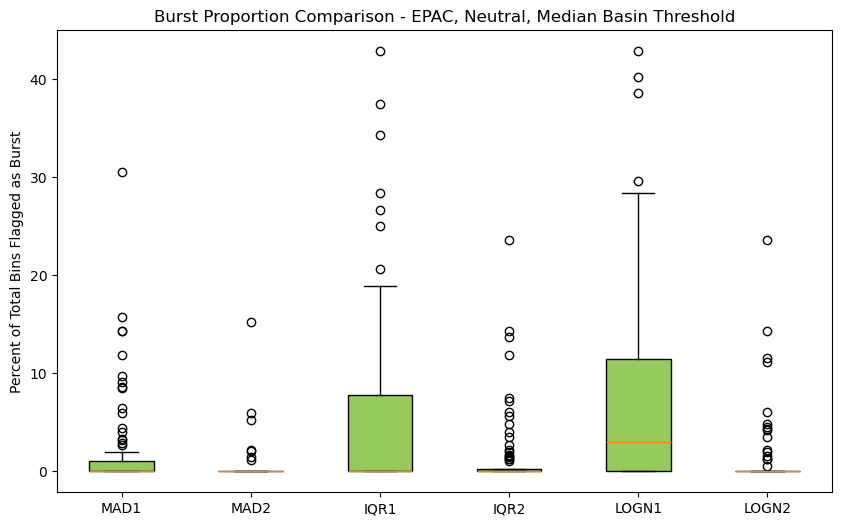

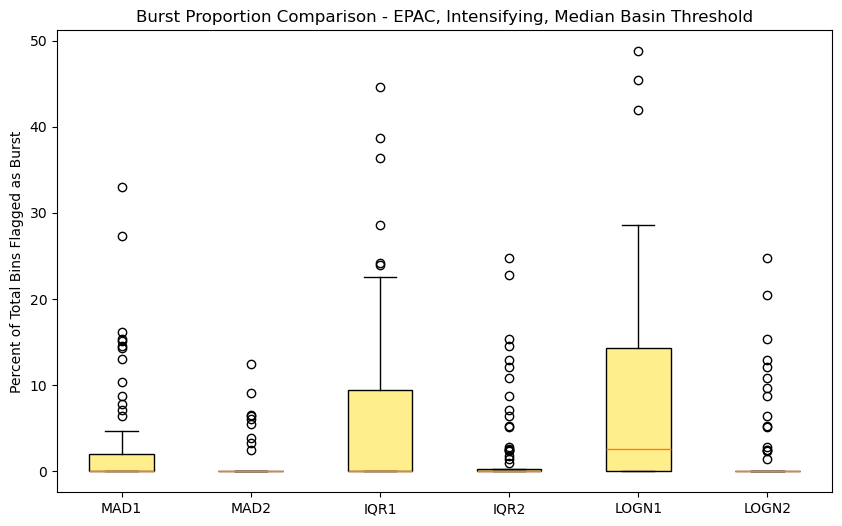

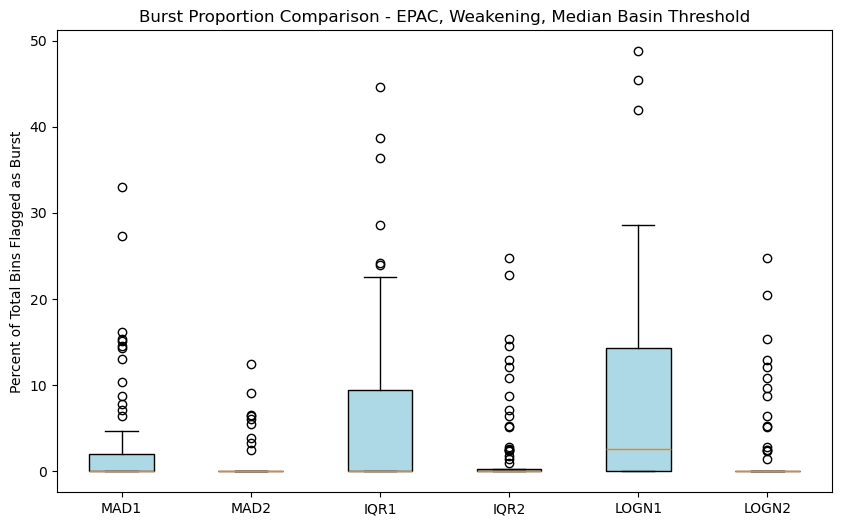

In [44]:
epac_basin_agg_result_neutral = epac_basin_agg_result[epac_basin_agg_result["Intensification_Category_3"]=="Neutral"]
# burst proportion comparison - neutral
plt.figure(figsize=(10, 6))
plt.boxplot([epac_basin_agg_result_neutral['mad1_prop'], epac_basin_agg_result_neutral['mad2_prop'], epac_basin_agg_result_neutral['iqr1_prop'],
             epac_basin_agg_result_neutral['iqr2_prop'], epac_basin_agg_result_neutral['logn1_prop'], epac_basin_agg_result_neutral['logn2_prop']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='#97c95c'))

# Customizing the Plot
plt.title('Burst Proportion Comparison - EPAC, Neutral, Median Basin Threshold')
plt.ylabel('Percent of Total Bins Flagged as Burst')

plt.show()

epac_basin_agg_result_intensifying = epac_basin_agg_result[epac_basin_agg_result["Intensification_Category_3"]=="Intensifying"]
# burst proportion comparison - intensifying
plt.figure(figsize=(10, 6))
plt.boxplot([epac_basin_agg_result_intensifying['mad1_prop'], epac_basin_agg_result_intensifying['mad2_prop'], epac_basin_agg_result_intensifying['iqr1_prop'],
             epac_basin_agg_result_intensifying['iqr2_prop'], epac_basin_agg_result_intensifying['logn1_prop'], epac_basin_agg_result_intensifying['logn2_prop']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='#FFEE8C'))

# Customizing the Plot
plt.title('Burst Proportion Comparison - EPAC, Intensifying, Median Basin Threshold')
plt.ylabel('Percent of Total Bins Flagged as Burst')

plt.show()

epac_basin_agg_result_weakening = epac_basin_agg_result[epac_basin_agg_result["Intensification_Category_3"]=="Intensifying"]
# burst proportion comparison - weakening
plt.figure(figsize=(10, 6))
plt.boxplot([epac_basin_agg_result_weakening['mad1_prop'], epac_basin_agg_result_weakening['mad2_prop'], epac_basin_agg_result_weakening['iqr1_prop'],
             epac_basin_agg_result_weakening['iqr2_prop'], epac_basin_agg_result_weakening['logn1_prop'], epac_basin_agg_result_weakening['logn2_prop']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Customizing the Plot
plt.title('Burst Proportion Comparison - EPAC, Weakening, Median Basin Threshold')
plt.ylabel('Percent of Total Bins Flagged as Burst')

plt.show()

<Figure size 1000x500 with 0 Axes>

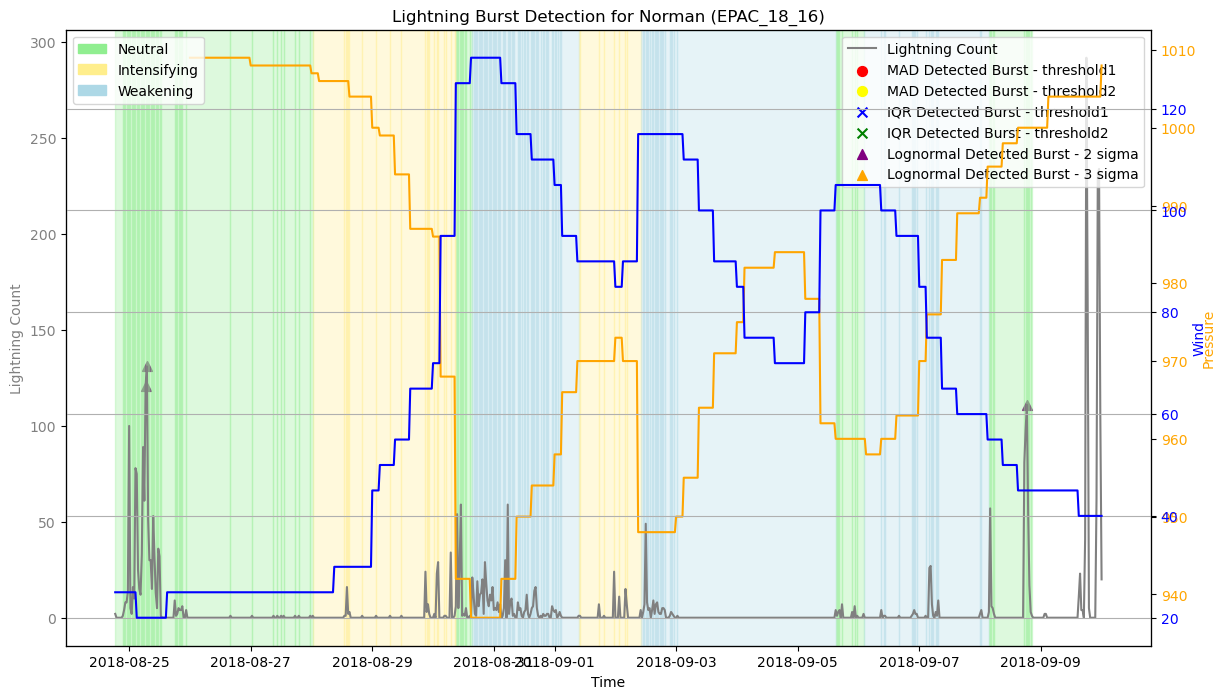

,storm_code,Intensification_Category_3,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,...,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
162,EPAC_18_16,Intensifying,0,0,5.274601,6.186646,0,0,4.601176,5.522526,...,0,4.341602,5.570385,29,0.0,0.0,0.0,0.0,0.0,0.0
163,EPAC_18_16,Neutral,0,0,5.668930,6.530878,0,0,4.922580,5.851414,...,0,4.681373,5.976382,79,0.0,0.0,0.0,0.0,3.8,0.0
164,EPAC_18_16,Weakening,0,0,4.897990,5.645644,0,0,4.269720,4.876431,...,0,4.415519,5.477840,103,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# look at one TC with the basin threshold applied
cyclone_id = 'EPAC_18_16'
cyclone_name = storm_names.filter(pl.col("storm_code") == cyclone_id)["storm_name"].item()
df_cyclone = epac_processed[epac_processed['storm_code'] == cyclone_id]
lightning_data = innercore_data.filter(pl.col("storm_code") == cyclone_id)

plt.figure(figsize=(10, 5))

# Create first y-axis
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(lightning_data['time_bin'], lightning_data['lightning_count'], label='Lightning Count', color='gray')
ax1.set_xlabel("Time")
ax1.set_ylabel("Lightning Count", color="gray")
ax1.tick_params(axis='y', labelcolor="gray")

# Create second y-axis for pressure
ax2 = ax1.twinx()
ax2.plot(lightning_data['time_bin'], lightning_data['pressure'], label='Pressure', color='orange')
ax2.set_ylabel("Pressure", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

# Create third y-axis for wind knot
ax2 = ax1.twinx()
ax2.plot(lightning_data['time_bin'], lightning_data['knots'], label='Wind', color='blue')
ax2.set_ylabel("Wind", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

# Mark bursts detected by MAD
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad1']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad1']],
            color='red', label='MAD Detected Burst - threshold1', s=50, marker='o')
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad2']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad2']],
            color='yellow', label='MAD Detected Burst - threshold2', s=50, marker='o')

# Mark bursts detected by IQR
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr1']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr1']],
            color='blue', label='IQR Detected Burst - threshold1', s=50, marker='x')
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr2']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr2']],
            color='green', label='IQR Detected Burst - threshold2', s=50, marker='x')

# Mark bursts detected by lognormal threshold
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_logn1']],
            df_cyclone['lightning_count'][df_cyclone['burst_logn1']],
            color='purple', label='Lognormal Detected Burst - 2 sigma', s=50, marker='^')
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_logn2']],
            df_cyclone['lightning_count'][df_cyclone['burst_logn2']],
            color='orange', label='Lognormal Detected Burst - 3 sigma', s=50, marker='^')

for i in range(len(df_cyclone) - 1):
    category = df_cyclone['Intensification_Category_3'].iloc[i]

    if category == "Neutral":
        color = 'lightgreen'
    elif category == "Intensifying":
        color = '#FFEE8C'
    elif category == "Weakening":
        color = 'lightblue'
    elif category == "Unidentified":
        color = 'white'
    else:
        color = 'red'

    ax1.axvspan(df_cyclone['time_bin'].iloc[i],
               df_cyclone['time_bin'].iloc[i + 1],
               color=color, alpha=0.3)
# Custom legend handles for background colors
green_patch = mpatches.Patch(color='lightgreen', label='Neutral')
yellow_patch = mpatches.Patch(color='#FFEE8C', label='Intensifying')
blue_patch = mpatches.Patch(color='lightblue', label='Weakening')

plt.xlabel('Time')
plt.title(f'Lightning Burst Detection for {cyclone_name} ({cyclone_id})')
ax1.legend()
ax2.legend(handles=[green_patch, yellow_patch, blue_patch], loc='upper left')
plt.xticks(visible=False)
plt.grid()
plt.show()

# print the summary for this storm
epac_basin_agg_result[epac_basin_agg_result["storm_code"] == cyclone_id]

### WPAC Basin

In [17]:
wpac_data = innercore_data.filter(pl.col("basin") == "WPAC")
wpac_storm_codes = wpac_data["storm_code"].unique()
wpac_storm_codes.head()

storm_code
str
"""WPAC_18_23"""
"""WPAC_13_11"""
"""WPAC_16_6"""
"""WPAC_15_22"""
"""WPAC_13_26"""
"""WPAC_15_21"""
"""WPAC_14_11"""
"""WPAC_15_6"""
"""WPAC_15_24"""


In [18]:
# basin-level summary of bursts
wpac_agg_result = agg_result[agg_result["storm_code"].isin(wpac_storm_codes)]

# median number of bursts by threshold, median threshold, median proportion
wpac_agg_summary_median = wpac_agg_result.drop(columns=("storm_code")).groupby("Intensification_Category_3").median()
wpac_agg_summary_median

,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
Intensification_Category_3,,,,,,,,,,,,,,,,,,,
Intensifying,0.0,0.0,5.570756,6.432644,0.0,0.0,4.936709,5.917647,1.0,0.0,4.653090,5.878437,42.0,0.0,0.0,0.0,0.0,2.3,0.0
Neutral,0.0,0.0,5.111313,5.974803,0.0,0.0,4.531210,5.409889,0.0,0.0,4.398219,5.523780,20.0,0.0,0.0,0.0,0.0,0.0,0.0
Weakening,0.0,0.0,4.829755,5.538058,0.0,0.0,3.990472,4.692809,0.0,0.0,4.179933,5.243620,20.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# mean number of bursts by threshold, mean threshold, mean proportion
wpac_agg_summary = wpac_agg_result.drop(columns=("storm_code")).groupby("Intensification_Category_3").mean()
wpac_agg_summary

,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins,mad1_prop,mad2_prop,iqr1_prop,iqr2_prop,logn1_prop,logn2_prop
Intensification_Category_3,,,,,,,,,,,,,,,,,,,
Intensifying,0.842466,0.479452,5.503139,6.375143,1.205479,0.321918,4.880512,5.809330,1.321918,0.034247,4.610695,5.819785,49.664384,3.581575,2.646096,3.734452,1.471507,2.979247,0.083082
Neutral,0.907801,0.687943,4.865623,5.575985,0.680851,0.241135,4.281773,5.026395,0.702128,0.028369,4.319397,5.390322,33.496454,4.821915,4.144610,3.984113,2.237376,1.809858,0.046454
Weakening,0.392157,0.245098,4.491891,5.109057,0.754902,0.186275,3.926278,4.552365,0.568627,0.019608,4.154982,5.128695,29.852941,2.805294,2.369412,2.751667,0.705294,1.438627,0.040000


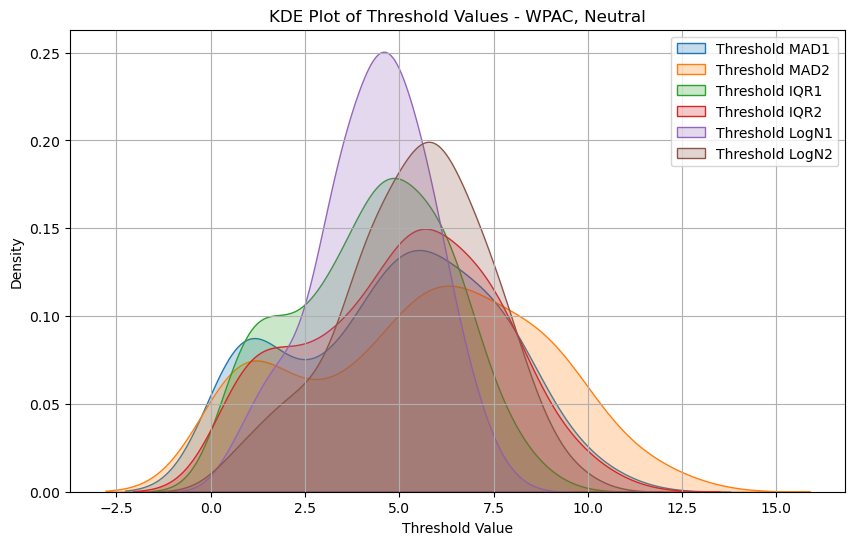

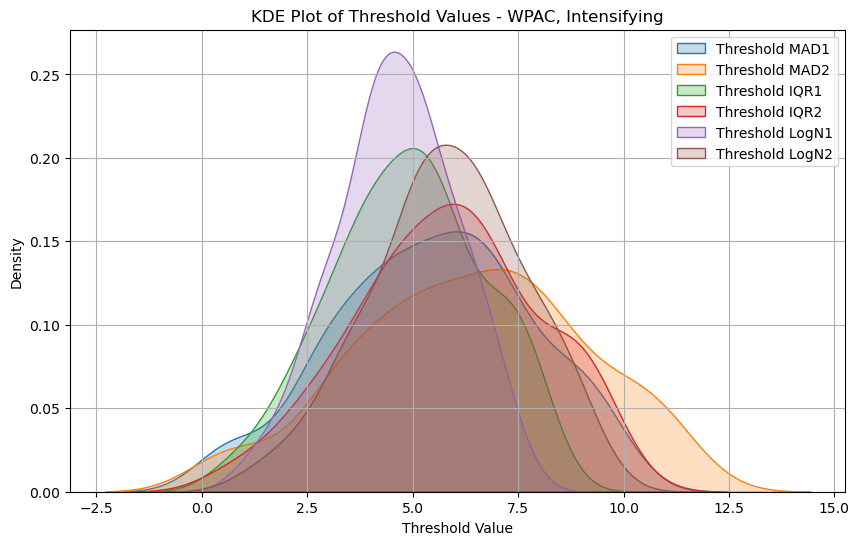

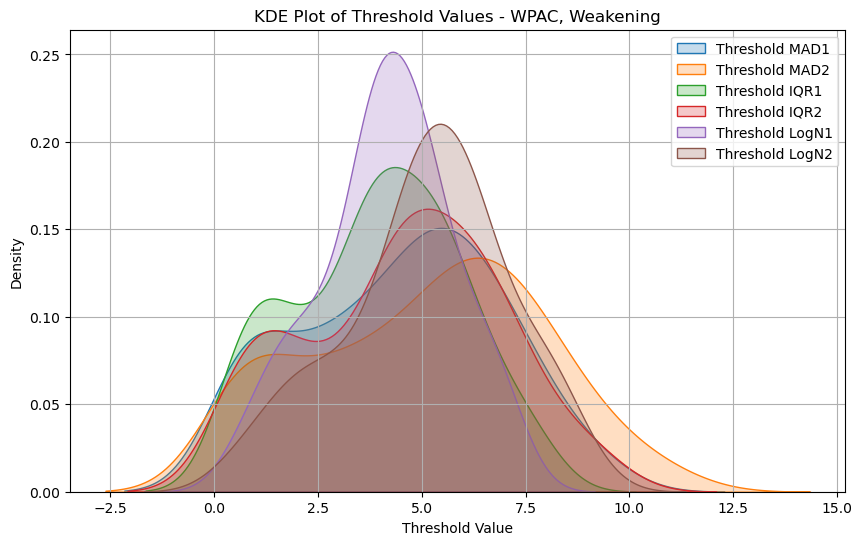

In [22]:
# Threshold value distribution
# Neutral bin
wpac_agg_result_neutral = wpac_agg_result[wpac_agg_result["Intensification_Category_3"]=="Neutral"]
plt.figure(figsize=(10, 6))

sns.kdeplot(wpac_agg_result_neutral['mad1_threshold'], label='Threshold MAD1', fill=True)
sns.kdeplot(wpac_agg_result_neutral['mad2_threshold'], label='Threshold MAD2', fill=True)
sns.kdeplot(wpac_agg_result_neutral['iqr1_threshold'], label='Threshold IQR1', fill=True)
sns.kdeplot(wpac_agg_result_neutral['iqr2_threshold'], label='Threshold IQR2', fill=True)
sns.kdeplot(wpac_agg_result_neutral['logn1_threshold'], label='Threshold LogN1', fill=True)
sns.kdeplot(wpac_agg_result_neutral['logn2_threshold'], label='Threshold LogN2', fill=True)

plt.xlabel('Threshold Value')
plt.ylabel('Density')
plt.title('KDE Plot of Threshold Values - WPAC, Neutral')
plt.legend()
plt.grid()
plt.show()

# Intensifying bin
wpac_agg_result_intensifying = wpac_agg_result[wpac_agg_result["Intensification_Category_3"]=="Intensifying"]
plt.figure(figsize=(10, 6))

sns.kdeplot(wpac_agg_result_intensifying['mad1_threshold'], label='Threshold MAD1', fill=True)
sns.kdeplot(wpac_agg_result_intensifying['mad2_threshold'], label='Threshold MAD2', fill=True)
sns.kdeplot(wpac_agg_result_intensifying['iqr1_threshold'], label='Threshold IQR1', fill=True)
sns.kdeplot(wpac_agg_result_intensifying['iqr2_threshold'], label='Threshold IQR2', fill=True)
sns.kdeplot(wpac_agg_result_intensifying['logn1_threshold'], label='Threshold LogN1', fill=True)
sns.kdeplot(wpac_agg_result_intensifying['logn2_threshold'], label='Threshold LogN2', fill=True)

plt.xlabel('Threshold Value')
plt.ylabel('Density')
plt.title('KDE Plot of Threshold Values - WPAC, Intensifying')
plt.legend()
plt.grid()
plt.show()

# Weakening bin
wpac_agg_result_weakening = wpac_agg_result[wpac_agg_result["Intensification_Category_3"]=="Weakening"]
plt.figure(figsize=(10, 6))

sns.kdeplot(wpac_agg_result_weakening['mad1_threshold'], label='Threshold MAD1', fill=True)
sns.kdeplot(wpac_agg_result_weakening['mad2_threshold'], label='Threshold MAD2', fill=True)
sns.kdeplot(wpac_agg_result_weakening['iqr1_threshold'], label='Threshold IQR1', fill=True)
sns.kdeplot(wpac_agg_result_weakening['iqr2_threshold'], label='Threshold IQR2', fill=True)
sns.kdeplot(wpac_agg_result_weakening['logn1_threshold'], label='Threshold LogN1', fill=True)
sns.kdeplot(wpac_agg_result_weakening['logn2_threshold'], label='Threshold LogN2', fill=True)

plt.xlabel('Threshold Value')
plt.ylabel('Density')
plt.title('KDE Plot of Threshold Values - WPAC, Weakening')
plt.legend()
plt.grid()
plt.show()

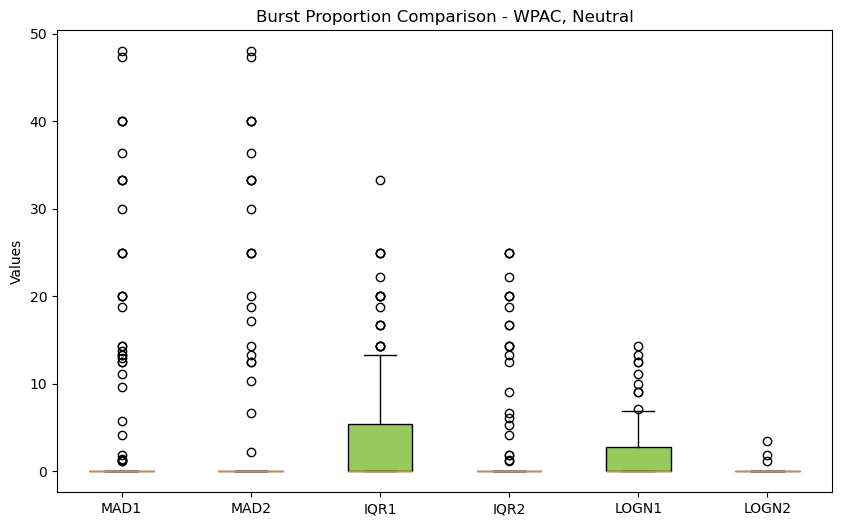

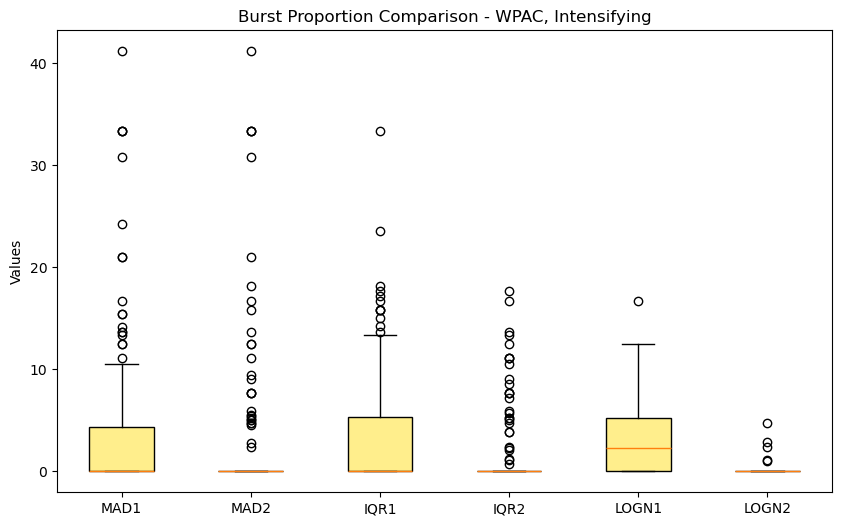

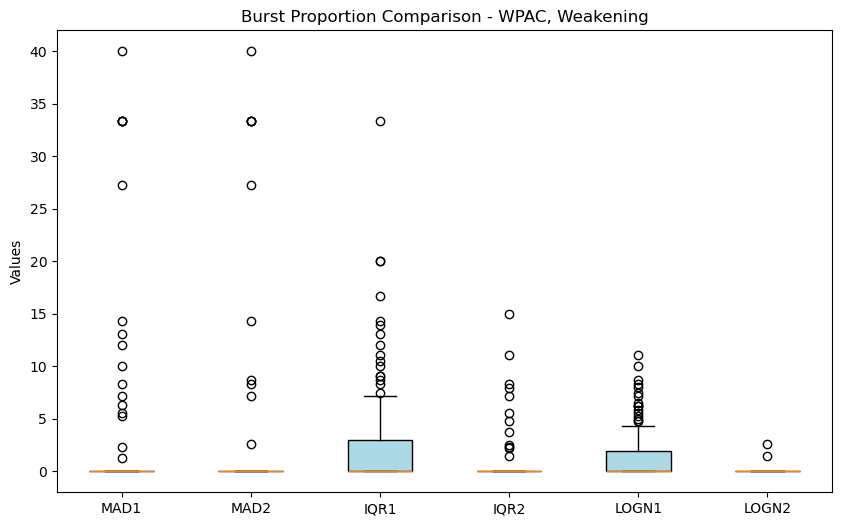

In [23]:
# burst proportion comparison - neutral
plt.figure(figsize=(10, 6))
plt.boxplot([wpac_agg_result_neutral['mad1_prop'], wpac_agg_result_neutral['mad2_prop'], wpac_agg_result_neutral['iqr1_prop'],
             wpac_agg_result_neutral['iqr2_prop'], wpac_agg_result_neutral['logn1_prop'], wpac_agg_result_neutral['logn2_prop']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='#97c95c'))

# Customizing the Plot
plt.title('Burst Proportion Comparison - WPAC, Neutral')
plt.ylabel('Values')

plt.show()

# burst proportion comparison - intensifying
plt.figure(figsize=(10, 6))
plt.boxplot([wpac_agg_result_intensifying['mad1_prop'], wpac_agg_result_intensifying['mad2_prop'], wpac_agg_result_intensifying['iqr1_prop'],
             wpac_agg_result_intensifying['iqr2_prop'], wpac_agg_result_intensifying['logn1_prop'], wpac_agg_result_intensifying['logn2_prop']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='#FFEE8C'))

# Customizing the Plot
plt.title('Burst Proportion Comparison - WPAC, Intensifying')
plt.ylabel('Values')

plt.show()

# burst proportion comparison - weakening
plt.figure(figsize=(10, 6))
plt.boxplot([wpac_agg_result_weakening['mad1_prop'], wpac_agg_result_weakening['mad2_prop'], wpac_agg_result_weakening['iqr1_prop'],
             wpac_agg_result_weakening['iqr2_prop'], wpac_agg_result_weakening['logn1_prop'], wpac_agg_result_weakening['logn2_prop']]
            , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
            patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Customizing the Plot
plt.title('Burst Proportion Comparison - WPAC, Weakening')
plt.ylabel('Values')

plt.show()